## Load modules

We use matplotlib for graphs, scipy and numpy for statistical functions and random distributions, and pyabc for inferring parameter sets. We additionally use line_profiler and memory_profiler to measure code performance.

In [1]:
import os
import tempfile

db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

In [2]:
#import modules, which consist of python command
import copy, random, functools, pickle, math
import numpy as np
import pandas as pd
from multiprocessing import Pool
from scipy import stats
from functools import partial

In [3]:
%matplotlib inline

from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition,
                   AdaptivePNormDistance)
from pyabc.visualization import plot_kde_2d
import matplotlib.pyplot as plt
import scipy as sp

/home/hz368/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/hz368/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
#load extensions
%load_ext line_profiler
%load_ext memory_profiler

In [5]:
import pickle
pickle_in = open("pickled_0.080_exp","rb")
syn = pickle.load(pickle_in)

In [6]:
def getLineage(filename):
    #reads a tsv file of clone counts
    df = pd.read_csv(filename, sep="\t")
    counts = np.transpose(df.values).astype(float)
    header = df.columns.values
    return(header[1:].astype(float),counts[1:])

In [7]:
times, counts = getLineage("DoupeAggregate.tsv")

In [8]:
from mpmath import *
import cmath

import math
def normal_round(n):
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [9]:
def F(x, y, t, r, gamma):
#     v = scipy.linalg.fractional_matrix_power(1 - 4 * r, 0.5)
    v = (1 - 4 * r)** 0.5    
#     w = (gamma * (1 - 2 * r) - 2 * r) / scipy.linalg.fractional_matrix_power(
#         2 * gamma * (1 - 4 * r), 0.5)
    w = (gamma * (1 - 2 * r) - 2 * r) / (2 * gamma * (1 - 4 * r)** 0.5)    
#     gg = scipy.linalg.fractional_matrix_power(1 - 4 * r, 0.5) / gamma
    gg = (1 - 4 * r)** 0.5 / gamma
    u = (1 - y) * np.exp(-gamma * t)
    u0 = (1 - y)
    Q = 1 + 2 * w - gg * u0 + (2 * r * (x - y) + y - 1) / gamma
    C = (-Q * whitm(w, 0, gg * u0) + (1 + 2 * w) * whitm(1 + w, 0, gg * u0)) / \
        (Q * whitw(w, 0, gg * u0) + 2 * whitw(1 + w, 0, gg * u0))
    f = 1 - u + \
        (u * (1 + v) - gamma * (1 + 2 * w)) / (2 * r) + \
        (gamma / (2 * r)) * ((1 + 2 * w) * whitm(1 + w, 0, u * gg) -
                             2 * C * whitw(1 + w, 0, u * gg)) / \
        (whitm(w, 0, u * gg) + C * whitw(w, 0, u * gg))
    return f


def Antal(z, t, r, gamma):
    g = []
    for k in range(len(z)):
        if z[k] == 1:
            g.append(1)
        else:
            g.append(F(z[k], z[k], t, r, gamma))
            
#     for k in range(1, len(z) + 1):
#         if z[k] == 1:
#             g[k] = 1
#         else:
#             g[k] = F(z[k], z[k], t, r, gamma)

    return g

In [10]:
def Psurv(t, l, r, rho):
    rho = rho - 0.00001
    gamma = rho / (1 - rho)
    T = l * t
    p = 1 - np.real(Antal([0], T, r, gamma))
#     if (p <= 0 or p > 1 or np.isnan(p)):
    if (p <= 0 or p > 1):
        p = Psurv(t, l, r + 0.00001, rho - 0.001)
    return p

In [11]:
def Pn(n, t, l, r, rho, N, returnConsecutive='', max_n=''):
    if max(n) >= N:
        N = max(n) + 1
    rho = rho - 0.00001
    assert (rho < 1)
    assert (rho > 0)
    gamma = rho / (1 - rho)
    T = l * t
#     k = range(N)
#     Gvals = Antal(cmath.exp(2 * np.pi * 1j * k / N), T, r, gamma)
    Gvals = Antal([cmath.exp(2 * np.pi * 1j * k / N) for k in range(int(N))], T, r, gamma)
    p = []

    if returnConsecutive:
        p = np.zeros(max_n)
#         for lp in range(1, len(n) + 1):
        for lp in range(len(n)):
#              p[n[lp]] = \
#                 np.real((1 / N) *
#                         sum(Gvals * np.exp(-2 * np.pi * 1j * k * n[lp] / N)))
            temporary = [cmath.exp(-2 * np.pi * 1j * k * n[lp] / N) for k in range(int(N))]
            p[n[lp]-1] = np.real((1 / N) *sum([a*b for a,b in zip(Gvals,temporary)]))
                               
    else:
#         for lp in range(1, len(n) + 1):
        for lp in range(len(n)):
#             p[lp] = \
#                 np.real((1 / N) * sum(Gvals *
#                                       np.exp(-2 * np.pi * 1j * k * n[lp] / N)))          
            Temporary = [cmath.exp(-2 * np.pi * 1j * k * n[lp] / N) for k in range(int(N))]
            p[lp] = np.real((1 / N) * sum(a*b for a,b in zip(Gvals,Temporary)))
#     print(Gvals)
    tst = sum(p)
    print(tst)
    if (tst > 1 or tst < 0 or np.isnan(tst)):
        print('Pathological point: r=' + str(r) + ' rho=' + str(
            rho) + '. Making 0.1% perturbation')
        p = Pn(n, t, l, r + 0.00001, rho - 0.001, N, returnConsecutive, max_n)

#     for x in range(len(p)):
#         if (p[x] < 0):
#             p[x] = 0

#     p[p < 0 & p > -1e-5] = 0

    return(p)

In [12]:
def logLikelihood(obs,lpBins,binSize):
    maxClone = len(lpBins)
    def noisyMul(a,b,i):
        #print("logP",lp, "\nobsv", obs); lp[i]*obs[i]
        print("logP",a, "\nobsv", b)
        return(a[i]*b[i])
    obsBins = [sum(obs[sum(binSize[0:n]):sum(binSize[0:(n+1)])]) for n in range(len(binSize))]
    return(sum([obsBins[j]*lpBins[j] for j in range(maxClone)]))

def allLogLike(obs,lpBins,binSize):
    return(sum([logLikelihood(o,p,binSize) for o,p in zip(obs,lpBins)]))

def logProbability(probability,binSize):
    binSizeList = [[sum(t[sum(binSize[0:n]):sum(binSize[0:(n+1)])]) for n in range(len(binSize))] for t in probability]
    logFreq = [[0 if n<=0 else math.log10(n) for n in t] for t in binSizeList]
    return(logFreq)

def calculateLikelihood(probability,binSize,data):
    lpBins = logProbability(probability, binSize)
    like = allLogLike(data,lpBins,binSize)
    #print(like)
    return(like)

In [13]:
def main(t,nRange,lambdaRange,rhoRange,rRange,binSize,data):
    maxN = max(list(map(max, nRange)))
    
#     PScanPP = np.zeros(len(lambdaRange), len(rhoRange), len(rRange),
#                        len(nRange), maxN)    
    PScanPP = [[[[np.zeros(maxN) for L4 in range(len(nRange))] for L3 in range(len(rRange))] for L2 in range(len(rhoRange))] for L1 in range(len(lambdaRange))]
    
#     PSurvScanPP = np.zeros(len(lambdaRange), len(rhoRange), len(rRange),
#                            len(nRange))    
    PSurvScanPP = [[[np.zeros(len(nRange)) for L3 in range(len(rRange))] for L2 in range(len(rhoRange))] for L1 in range(len(lambdaRange))]

    timePoints = range(len(t))
    nBadValues = 0

    for L1 in range(len(lambdaRange)):       
        PScanPP_local = [[[np.zeros(maxN) for L4 in range(len(nRange))] for L3 in range(len(rRange))] for L2 in range(len(rhoRange))]
             
        PSurvScanPP_local = [[np.zeros(len(nRange)) for L3 in range(len(rRange))] for L2 in range(len(rhoRange))]

        for L2 in range(len(rhoRange)):
            for L3 in range(len(rRange)):
                for L4 in timePoints:
                    probS = Psurv(t[L4], lambdaRange[L1], rRange[L3], rhoRange[L2])
                    avgN = 1 / probS
                    Niter = max([normal_round(int(4*avgN)), normal_round(1.5*max(nRange[L4])), 10])
                    probN = Pn(nRange[L4], t[L4], lambdaRange[L1], rRange[L3],
                               rhoRange[L2], Niter, 'returnConsecutive', maxN)

                    if any(probN > 1) or \
                            sum(probN) > 1 or \
                            probS > 1 or \
                            probS <0 or \
                            abs(probS-sum(probN))>1e-3:
                        print('Bad values at time t=' + str(t[L4]) + ' lambda=' + str(lambdaRange[L1]) + ' rho=' + str(rhoRange[L2]) + ' r=' + str(rRange[L3]))
                        print('any(probN>1=' + str(any(probN>1)) + ', sum(probN)>1=' + str(sum(probN)>1) + ', (probS-sum(probN))=' + str(probS-sum(probN)))
                        nBadValues += 1
                    else:
                        print('Completed time t=' + str(t[L4]) + ' weeks, lambda=' + str(lambdaRange[L1]) + ' rho=' + str(rhoRange[L2]) + ' r=' + str(rRange[L3]))
    
#                     PSurvScanPP_local[L2][L3][L4] = probS
                    PScanPP_local[L2][L3][L4][:] = probN/probS
                PScanPP_local[L2][L3] = calculateLikelihood(PScanPP_local[L2][L3],binSize,data)
        PSurvScanPP[L1] = PSurvScanPP_local
        PScanPP[L1] = PScanPP_local

    return(PScanPP) 

In [14]:
nSize = len(np.transpose(counts))
nBin = int(round(np.log(nSize)/np.log(2)+0.5))
binSize = np.append([1],[2**(n-1) for n in range(1,(nBin+1))])


In [15]:
t = times/7
nRange = [list(range(1, max(np.where(t>0)[0])+1)) for t in syn]
lambdaRange = [2.9]
bins=50
rhoRange = [(i*0.8/bins) for i in range(1,bins)]
rRange = [(i*0.2/bins) for i in range(1,bins)]


In [16]:
%time result = main(t,nRange,lambdaRange,rhoRange,rRange,binSize,syn)

0.999937095673578
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.016 r=0.004
0.9991799786084202
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.016 r=0.004
0.996915726558555
Bad values at time t=3.0 lambda=2.9 rho=0.016 r=0.004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0030224260280108384')]
0.9753890704106425
Bad values at time t=6.0 lambda=2.9 rho=0.016 r=0.004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.024334363499889378')]
0.9634480857321388
Bad values at time t=12.0 lambda=2.9 rho=0.016 r=0.004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.035370220232622263')]
0.9535773780824237
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.016 r=0.004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.040488629671747045')]
0.9419361641586059
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.016 r=0.004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0274

0.977253173847615
Bad values at time t=3.0 lambda=2.9 rho=0.016 r=0.032
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.02225487361729217')]
0.9023869455368799
Bad values at time t=6.0 lambda=2.9 rho=0.016 r=0.032
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.09543200896064874')]
0.8803485741110095
Bad values at time t=12.0 lambda=2.9 rho=0.016 r=0.032
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.11052405482708982')]
0.8627701175078548
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.016 r=0.032
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.094383612003895667')]
0.7658824890504117
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.016 r=0.032
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.057363837448682897')]
0.9997706158576437
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.016 r=0.036000000000000004
0.994310264449817
Bad values at time t=1.4285714285714286 lam

0.9604157729648947
Bad values at time t=3.0 lambda=2.9 rho=0.016 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.038667047815322042')]
0.8820767404951995
Bad values at time t=6.0 lambda=2.9 rho=0.016 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.1138908934917171')]
0.8749939345131439
Bad values at time t=12.0 lambda=2.9 rho=0.016 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.10845587841886428')]
0.8518500601610796
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.016 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.074725426207471801')]
0.6964710157896136
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.016 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.040236782578087271')]
0.9996048038937044
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.016 r=0.064
0.989652311323447
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.016 r

0.8794030036550077
Bad values at time t=12.0 lambda=2.9 rho=0.016 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.097088233130287915')]
0.840585630324292
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.016 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.060033077993180806')]
0.6463835491702344
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.016 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.030818456424058449')]
0.9994223402233786
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.016 r=0.09200000000000001
0.9849554040830801
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.016 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014788853559637438')]
0.9459824951727172
Bad values at time t=3.0 lambda=2.9 rho=0.016 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf

0.8838752541368119
Bad values at time t=12.0 lambda=2.9 rho=0.016 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.086072063191445447')]
0.827660002066901
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.016 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.050508270978876557')]
0.6073626223909665
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.016 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.025415299747130415')]
0.9992250833270797
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.016 r=0.12
0.9804041034819005
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.016 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.019262954747348959')]
0.9370170887633296
Bad values at time t=3.0 lambda=2.9 rho=0.016 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.061170526652255308')]
0.8803416872602934


0.9990147162945149
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.016 r=0.14800000000000002
0.9761021866919843
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.016 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.023487965324294757')]
0.9306872262622412
Bad values at time t=3.0 lambda=2.9 rho=0.016 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.067089895751080153')]
0.8842517199459523
Bad values at time t=6.0 lambda=2.9 rho=0.016 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.10621594094006803')]
0.8871355085984641
Bad values at time t=12.0 lambda=2.9 rho=0.016 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.075786830834397967')]
0.8123751953658833
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.016 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.04345985722

0.549753388117305
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.016 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.019590584598435323')]
0.9987927570243829
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.016 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011851423181157283')]
0.9721025305168647
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.016 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.027411006675642113')]
0.9263319892360082
Bad values at time t=3.0 lambda=2.9 rho=0.016 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.071039145207792087')]
0.888514858975476
Bad values at time t=6.0 lambda=2.9 rho=0.016 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.10029622974035346')]
0.8884033894512948
Bad values at time t=12.0 lambda=2.9 rho=0.016 r=0.17600000000000002
any(pro

0.9661884252304527
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.032 r=0.004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0068010846310941897')]
0.8569279893825577
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.032 r=0.004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.002509624889966533')]
0.9999193028865413
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.032 r=0.008
0.9987916557402443
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.032 r=0.008
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011181239682869215')]
0.9955036046645104
Bad values at time t=3.0 lambda=2.9 rho=0.032 r=0.008
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0040009734982463518')]
0.9725494988132073
Bad values at time t=6.0 lambda=2.9 rho=0.032 r=0.008
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.025238407678501718')]
0.9661596198563598
Bad values at time t=12.0 lambda=2.9

0.45262466796358697
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.032 r=0.032
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.036398521843745868')]
0.9997668280664616
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.032 r=0.036000000000000004
0.9947330829309875
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.032 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0048625026424149453')]
0.9781619818400102
Bad values at time t=3.0 lambda=2.9 rho=0.032 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.019634817178989294')]
0.9142672597715876
Bad values at time t=6.0 lambda=2.9 rho=0.032 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.076081318557591593')]
0.8815651617994898
Bad values at time t=12.0 lambda=2.9 rho=0.032 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.07862391272224977

0.341638810464183
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.032 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.029739675468279714')]
0.9995953963223376
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.032 r=0.064
0.9902147699800222
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.032 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0090690509359104832')]
0.9620380503551946
Bad values at time t=3.0 lambda=2.9 rho=0.032 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.034090505831152695')]
0.8885855425190988
Bad values at time t=6.0 lambda=2.9 rho=0.032 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.094758672664561172')]
0.8496957574692376
Bad values at time t=12.0 lambda=2.9 rho=0.032 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.084607375590083134')]
0.6864756331046002
Bad values at time t=25.714285714285715 lambda=2.9 rho

0.9855690140713717
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.032 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013405441310391342')]
0.948900770102467
Bad values at time t=3.0 lambda=2.9 rho=0.032 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.045597554922645722')]
0.8771606558798176
Bad values at time t=6.0 lambda=2.9 rho=0.032 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.099571810466982824')]
0.8324127270629158
Bad values at time t=12.0 lambda=2.9 rho=0.032 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.079348959964740562')]
0.6377256336587673
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.032 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.046472003796455219')]
0.2804778252090271
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.032 r=0.09200000000

0.9809975714082076
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.032 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017669887721899813')]
0.9387022601432727
Bad values at time t=3.0 lambda=2.9 rho=0.032 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.054202401171036585')]
0.871923588737496
Bad values at time t=6.0 lambda=2.9 rho=0.032 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.098552991408069057')]
0.819610325194255
Bad values at time t=12.0 lambda=2.9 rho=0.032 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.07226582150241212')]
0.6009092014982186
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.032 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.039605442786696199')]
0.24772317472009714
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.032 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018939645807376115

0.8085630994148825
Bad values at time t=12.0 lambda=2.9 rho=0.032 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.065580453952456264')]
0.5713330973086763
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.032 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.034421654922117018')]
0.2244404310808911
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.032 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016088042974496813')]
0.9989548658653379
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.032 r=0.15200000000000002
0.9760129189902779
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.032 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022306550830795246')]
0.9300039885396194
Bad values at time t=3.0 lambda=2.9 rho=0.032 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mp

0.8680718844305922
Bad values at time t=6.0 lambda=2.9 rho=0.032 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.090836180625668672')]
0.7984050364593225
Bad values at time t=12.0 lambda=2.9 rho=0.032 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.059781578191252738')]
0.5466938556258442
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.032 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.030499388058230825')]
0.20677616696696166
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.032 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013992218547700164')]
0.9987246143126349
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.032 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011831716014769622')]
0.9719311150826566
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.032 r=0.18
any(

0.9805823284987232
Bad values at time t=6.0 lambda=2.9 rho=0.04800000000000001 r=0.008
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014436309766036937')]
0.9682471546329776
Bad values at time t=12.0 lambda=2.9 rho=0.04800000000000001 r=0.008
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0097435684181472748')]
0.8781239326762325
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.04800000000000001 r=0.008
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0060897368407388797')]
0.6196062490117004
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.04800000000000001 r=0.008
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0028445545624044')]
0.9998960887091117
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.04800000000000001 r=0.012000000000000002
0.99835835665176
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.04800000000000001 r=0.012000000000000002
any(probN>1=False, sum(probN)>1=F

0.9997528356746217
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.04800000000000001 r=0.036000000000000004
0.9948713022127669
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.04800000000000001 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0042137472631311734')]
0.979661333444959
Bad values at time t=3.0 lambda=2.9 rho=0.04800000000000001 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01540982581842687')]
0.9216620997136057
Bad values at time t=6.0 lambda=2.9 rho=0.04800000000000001 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.057006167853231315')]
0.8593003180984199
Bad values at time t=12.0 lambda=2.9 rho=0.04800000000000001 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.054557649549040188')]
0.6205068451016827
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.04800000000000001 r=0.036000

0.804390124320304
Bad values at time t=12.0 lambda=2.9 rho=0.04800000000000001 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.066113989543806984')]
0.5206160564124674
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.04800000000000001 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.043441096549759917')]
0.18874714676617757
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.04800000000000001 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.023262200443716602')]
0.9995680052954806
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.04800000000000001 r=0.064
0.9903195868551748
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.04800000000000001 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0080633632586664117')]
0.9629779113835788
Bad values at time t=3.0 lambda=2.9 rho=0.04800000000000001 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf(

0.9504014011695452
Bad values at time t=3.0 lambda=2.9 rho=0.04800000000000001 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.03793974292516622')]
0.8673864107538445
Bad values at time t=6.0 lambda=2.9 rho=0.04800000000000001 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.084698887867336925')]
0.762699233626252
Bad values at time t=12.0 lambda=2.9 rho=0.04800000000000001 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.066472681877404072')]
0.4524613833061491
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.04800000000000001 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.038919512203548556')]
0.14495274564933186
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.04800000000000001 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.019617918191009054')]
0.9993660383107676
Comple

0.41304216684627815
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.04800000000000001 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.034712176691550245')]
0.12305570426698506
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.04800000000000001 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016960808016166534')]
0.9991806860828254
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.04800000000000001 r=0.11600000000000002
0.9814997329550574
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.04800000000000001 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015600867245896932')]
0.938097606666512
Bad values at time t=3.0 lambda=2.9 rho=0.04800000000000001 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.046795323096120556')]
0.8527521982958728
Bad values at time t=6.0 lambda=2.9 rho=0.04800000000000001

0.7114012787855738
Bad values at time t=12.0 lambda=2.9 rho=0.04800000000000001 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.058566970642431104')]
0.37900111812733944
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.04800000000000001 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.030486594589273108')]
0.10596699545320144
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.04800000000000001 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014540450917831502')]
0.9989516495270617
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.04800000000000001 r=0.14400000000000002
0.9768772138912434
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.04800000000000001 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.019544216210761967')]
0.9281165931616254
Bad values at time t=3.0 lambda=2.9 rho=0.04800000000000001 r=0.14400000000000002
any(probN>1=False, s

0.973079452732998
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.04800000000000001 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022765997430230556')]
0.9211087820066785
Bad values at time t=3.0 lambda=2.9 rho=0.04800000000000001 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.057678436967789071')]
0.8353362080736025
Bad values at time t=6.0 lambda=2.9 rho=0.04800000000000001 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.083109635274778104')]
0.690626686048083
Bad values at time t=12.0 lambda=2.9 rho=0.04800000000000001 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.053955196585998566')]
0.35289687855207247
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.04800000000000001 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.027045949996407359')]
0.09392036816752401
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.04800000000000001 

0.8293763804271849
Bad values at time t=6.0 lambda=2.9 rho=0.04800000000000001 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.080304645363668548')]
0.6750992847666106
Bad values at time t=12.0 lambda=2.9 rho=0.04800000000000001 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.050340836732679861')]
0.3347311547241943
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.04800000000000001 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.024621137087090073')]
0.08604687249158934
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.04800000000000001 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011416537199570406')]
0.9984946349966952
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.04800000000000001 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012750939682417695')]
0.9688815846401316
B

0.9959971383713477
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.064 r=0.028000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0027286931771111078')]
0.9844338459662493
Bad values at time t=3.0 lambda=2.9 rho=0.064 r=0.028000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0087534445697680097')]
0.9371394080737092
Bad values at time t=6.0 lambda=2.9 rho=0.064 r=0.028000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.033457311270210788')]
0.8529123021171294
Bad values at time t=12.0 lambda=2.9 rho=0.064 r=0.028000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.029102027393709484')]
0.5631057834170813
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.064 r=0.028000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022703142511362628')]
0.2601066358150305
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.064 r=0.028

0.9913677446114361
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.064 r=0.05600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0061040656734973053')]
0.966369161509801
Bad values at time t=3.0 lambda=2.9 rho=0.064 r=0.05600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.020334752145270918')]
0.8861987836021588
Bad values at time t=6.0 lambda=2.9 rho=0.064 r=0.05600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.05874093890014076')]
0.7512121810161122
Bad values at time t=12.0 lambda=2.9 rho=0.064 r=0.05600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.049984371758874047')]
0.40522574654159255
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.064 r=0.05600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.033635537568042773')]
0.1472550256466207
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.064 r=0.0560000000

0.8513662299094887
Bad values at time t=6.0 lambda=2.9 rho=0.064 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.070926110042759505')]
0.6865433823938574
Bad values at time t=12.0 lambda=2.9 rho=0.064 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.05499594614212322')]
0.32838472547061703
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.064 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.03276219067351771')]
0.10439843513176825
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.064 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017018392751338124')]
0.9993307210817948
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.064 r=0.08800000000000001
0.9856787760285493
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.064 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010383885774385204')]
0.9471878036914303
Bad values

0.8265605263152389
Bad values at time t=6.0 lambda=2.9 rho=0.064 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.075544004109020291')]
0.6411864274289764
Bad values at time t=12.0 lambda=2.9 rho=0.064 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.054020697668372031')]
0.28237834546832663
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.064 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.029710909208035652')]
0.08200829281324883
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.064 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014843984948451863')]
0.9990935813012543
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.064 r=0.11600000000000002
0.9806238248475329
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.064 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[

0.25121991830066004
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.064 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.026625062884831463')]
0.06818635257655453
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.064 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012973982932888706')]
0.9988423963124273
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.064 r=0.14400000000000002
0.9756535663655234
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.064 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018002624988732285')]
0.9204435805910078
Bad values at time t=3.0 lambda=2.9 rho=0.064 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.047757626157734379')]
0.805373927941049
Bad values at time t=6.0 lambda=2.9 rho=0.064 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.07613674615670063')]
0.60

0.2284172050236639
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.064 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.023922946604772372')]
0.05875334394780071
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.064 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011457660959926869')]
0.9985786797424793
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.064 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010547484762809534')]
0.9708578794251297
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.064 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.021622529982864513')]
0.9100668578380544
Bad values at time t=3.0 lambda=2.9 rho=0.064 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.052770236275126337')]
0.7906417848541915
Bad values at time t=6.0 lambda=2.9 rho=0.064 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[

0.7798633012794218
Bad values at time t=6.0 lambda=2.9 rho=0.064 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.072681274826521092')]
0.5563271230814641
Bad values at time t=12.0 lambda=2.9 rho=0.064 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.04449387416049122')]
0.21083160390096045
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.064 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.021634182415930847')]
0.05187355284054358
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.064 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010231401747704358')]
0.9999385641319419
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.08 r=0.004
0.9993866739661814
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.08 r=0.004
0.9979508147026006
Completed time t=3.0 weeks, lambda=2.9 rho=0.08 r=0.004
0.9914975108831441
Bad values at time t=6.0 lambda=2.9 rho=0.08 r=0.

0.9219078348644497
Bad values at time t=6.0 lambda=2.9 rho=0.08 r=0.032
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.027421807348456784')]
0.7888311144649152
Bad values at time t=12.0 lambda=2.9 rho=0.08 r=0.032
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022066714819673261')]
0.4555903602559803
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.08 r=0.032
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016677982404238234')]
0.21185334507207096
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.08 r=0.032
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010245291247807958')]
0.9996917083417194
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.08 r=0.036000000000000004
0.9943085832515027
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.08 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0031266898340899241')]
0.9772334012911216
Bad values a

0.6717321830838447
Bad values at time t=12.0 lambda=2.9 rho=0.08 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0398092850442886')]
0.312419489224886
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.08 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.026547175729387751')]
0.12070970398082655
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.08 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014907597178920026')]
0.9994548461488223
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.08 r=0.064
0.9891703763933355
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.08 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0063154594476240167')]
0.9573419191527137
Bad values at time t=3.0 lambda=2.9 rho=0.08 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.019448125833392949')]
0.8564634004131294
Bad values at time t=6.0 lambda=2.9 rho=0.08 r=0

0.08440441993579487
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.08 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014369809070750111')]
0.9992006008926358
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.08 r=0.09200000000000001
0.983740589798376
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.08 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0098341190002204648')]
0.9386448034465498
Bad values at time t=3.0 lambda=2.9 rho=0.08 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.028968180486874662')]
0.8150550358521836
Bad values at time t=6.0 lambda=2.9 rho=0.08 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0619837299249556')]
0.5880927795628883
Bad values at time t=12.0 lambda=2.9 rho=0.08 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.04598316694971194

0.06527661772553017
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.08 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012945624374384623')]
0.9989307753404384
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.08 r=0.12
0.9782381929351252
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.08 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013462503630335965')]
0.9219623077181394
Bad values at time t=3.0 lambda=2.9 rho=0.08 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.036989575728976876')]
0.7836884610675785
Bad values at time t=6.0 lambda=2.9 rho=0.08 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.066597701899731909')]
0.5384490397980849
Bad values at time t=12.0 lambda=2.9 rho=0.08 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.045997950669454668')]
0.19851126070045458
Bad values at time t=25.714285714285715 lambda=2

0.9073765447861419
Bad values at time t=3.0 lambda=2.9 rho=0.08 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.043383943171506401')]
0.7589155174982241
Bad values at time t=6.0 lambda=2.9 rho=0.08 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.067830367497890398')]
0.5013103615970487
Bad values at time t=12.0 lambda=2.9 rho=0.08 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.044197387355133566')]
0.17315662101899806
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.08 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022962084463750393')]
0.05217959923767911
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.08 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011364530897313936')]
0.9986054114592042
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.08 r=0.1520000000

0.8946940578902839
Bad values at time t=3.0 lambda=2.9 rho=0.08 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.048303996585765341')]
0.7385901035226612
Bad values at time t=6.0 lambda=2.9 rho=0.08 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.067231224886353358')]
0.4721366941436206
Bad values at time t=12.0 lambda=2.9 rho=0.08 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.041799943250343641')]
0.15484942851628847
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.08 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.020923173817276819')]
0.04458066168057739
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.08 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010187928520337793')]
0.9983074938268024
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.08 r=0.18
any(probN>

0.7333597226041458
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.09600000000000002 r=0.008
0.5064966658153487
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.09600000000000002 r=0.008
0.9998649223739667
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.09600000000000002 r=0.012000000000000002
0.9980106581826571
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.09600000000000002 r=0.012000000000000002
0.9920183733603418
Bad values at time t=3.0 lambda=2.9 rho=0.09600000000000002 r=0.012000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013743385497873017')]
0.9668909068267572
Bad values at time t=6.0 lambda=2.9 rho=0.09600000000000002 r=0.012000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.004425912767580864')]
0.8840431328101792
Bad values at time t=12.0 lambda=2.9 rho=0.09600000000000002 r=0.012000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0

0.7173450821337073
Bad values at time t=12.0 lambda=2.9 rho=0.09600000000000002 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017315257549471941')]
0.38068406601840316
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.09600000000000002 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012866096901164414')]
0.1814729437709144
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.09600000000000002 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0078987438244846053')]
0.9996048556893928
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.09600000000000002 r=0.04
0.9928333184479051
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.09600000000000002 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0030555206365828758')]
0.9704650662034014
Bad values at time t=3.0 lambda=2.9 rho=0.09600000000000002 r=0.04
any(probN>1=Fals

0.9879271793906137
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.09600000000000002 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0055628261710720661')]
0.9511995562789808
Bad values at time t=3.0 lambda=2.9 rho=0.09600000000000002 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015974541199901049')]
0.8326624528692607
Bad values at time t=6.0 lambda=2.9 rho=0.09600000000000002 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.041471162136686002')]
0.5931311541181407
Bad values at time t=12.0 lambda=2.9 rho=0.09600000000000002 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.032307836021710279')]
0.2555130430089692
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.09600000000000002 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.021496955856375399')]
0.10592067181974979
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.0960000000000000

0.20102918765653383
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.09600000000000002 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.023012873804128475')]
0.07747217923516793
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.09600000000000002 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012407668455044804')]
0.999072828552186
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.09600000000000002 r=0.09200000000000001
0.9819298080723814
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.09600000000000002 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0088232125673882722')]
0.9297623708396299
Bad values at time t=3.0 lambda=2.9 rho=0.09600000000000002 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.024714156163268886')]
0.7819161297437132
Bad values at time t=6.0 lambda=2.9 rho=0.0960000000000000

0.976708740762571
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.09600000000000002 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011749345226966801')]
0.9129203112798979
Bad values at time t=3.0 lambda=2.9 rho=0.09600000000000002 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.031355437372772799')]
0.7477851358928388
Bad values at time t=6.0 lambda=2.9 rho=0.09600000000000002 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.057692956856284172')]
0.4664959332202405
Bad values at time t=12.0 lambda=2.9 rho=0.09600000000000002 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.039783453757642695')]
0.16277498196278792
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.09600000000000002 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022319990461333955')]
0.059020644001354844
Bad

0.0491085638576527
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.09600000000000002 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010690060252913101')]
0.998486869560365
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.09600000000000002 r=0.14400000000000002
0.9706539741269224
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.09600000000000002 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015184148637056305')]
0.8952491253722017
Bad values at time t=3.0 lambda=2.9 rho=0.09600000000000002 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.037841777266826249')]
0.7156889774208219
Bad values at time t=6.0 lambda=2.9 rho=0.09600000000000002 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.060312229135661477')]
0.4252872228835516
Bad values at time t=12.0 lambda=2.9 rho=0.09600000000000002 r=0.14400000000000002
any(prob

0.6929649980442489
Bad values at time t=6.0 lambda=2.9 rho=0.09600000000000002 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.060829940807955563')]
0.39789721691241653
Bad values at time t=12.0 lambda=2.9 rho=0.09600000000000002 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.037984696598533652')]
0.1229007698416
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.09600000000000002 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01947751228656916')]
0.04115719516234635
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.09600000000000002 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0096995751495972254')]
0.9981525507101977
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.09600000000000002 r=0.172
0.9647322037239183
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.09600000000000002 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf

0.11121534564154638
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.09600000000000002 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018171535053461876')]
0.03620439341236118
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.09600000000000002 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0089420834361633936')]
0.9978568648488414
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.09600000000000002 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011667856665683596')]
0.95981130955313
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.09600000000000002 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.021317988188108927')]
0.8676491072365174
Bad values at time t=3.0 lambda=2.9 rho=0.09600000000000002 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.046464393317035779')]
0.6705214507994806
Bad values at t

0.7232061733561429
Bad values at time t=12.0 lambda=2.9 rho=0.11200000000000002 r=0.028000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0071422896405654024')]
0.41357315045341825
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.11200000000000002 r=0.028000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0050985511738449452')]
0.21755320649873988
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.11200000000000002 r=0.028000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0031175722107367188')]
0.9996268690299224
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.11200000000000002 r=0.032
0.9935330067721745
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.11200000000000002 r=0.032
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0019602495992968594')]
0.9724349523240446
Bad values at time t=3.0 lambda=2.9 rho=0.11200000000000002 r=0.032
any(probN>

0.9881214446061497
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.11200000000000002 r=0.05600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0040878810879378946')]
0.9504280638006933
Bad values at time t=3.0 lambda=2.9 rho=0.11200000000000002 r=0.05600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010785320017407396')]
0.8252221917908826
Bad values at time t=6.0 lambda=2.9 rho=0.11200000000000002 r=0.05600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.029089386249744109')]
0.5686821161955127
Bad values at time t=12.0 lambda=2.9 rho=0.11200000000000002 r=0.05600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.02211052975041139')]
0.2561969393931806
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.11200000000000002 r=0.05600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01547851515033799')]
0.11643084630067943
Bad v

0.19230363318504992
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.11200000000000002 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.019055432809575695')]
0.08157074328752596
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.11200000000000002 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010623648655732884')]
0.9990123607702491
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.11200000000000002 r=0.084
0.9814708873054467
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.11200000000000002 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0070066821738405949')]
0.9254657725434536
Bad values at time t=3.0 lambda=2.9 rho=0.11200000000000002 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018781191902732086')]
0.761558829377367
Bad values at time t=6.0 lambda=2.9 rho=0.11200000000000002 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf

0.9055135609155847
Bad values at time t=3.0 lambda=2.9 rho=0.11200000000000002 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.025264804969736598')]
0.7186071956267273
Bad values at time t=6.0 lambda=2.9 rho=0.11200000000000002 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.048671231045153807')]
0.41853278112757736
Bad values at time t=12.0 lambda=2.9 rho=0.11200000000000002 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.033889198229398898')]
0.14959606932904057
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.11200000000000002 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.019776795416708293')]
0.06010428455053676
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.11200000000000002 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010543078938962086')]
0.998657889622539
Com

0.049009015191706494
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.11200000000000002 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0099830630103239573')]
0.9983425547377945
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.11200000000000002 r=0.136
0.9688458071936066
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.11200000000000002 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012970381887303706')]
0.8842890226687781
Bad values at time t=3.0 lambda=2.9 rho=0.11200000000000002 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.031882011453235437')]
0.6784772534882302
Bad values at time t=6.0 lambda=2.9 rho=0.11200000000000002 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.052915671786428753')]
0.37226582063234803
Bad values at time t=12.0 lambda=2.9 rho=0.11200000000000002 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.034774

0.6503748281381451
Bad values at time t=6.0 lambda=2.9 rho=0.11200000000000002 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.054529753483693377')]
0.34241366339130413
Bad values at time t=12.0 lambda=2.9 rho=0.11200000000000002 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.034341035788697127')]
0.10743071591921881
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.11200000000000002 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018112932139026552')]
0.040354050826243035
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.11200000000000002 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0092100822962843526')]
0.9979625520162412
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.11200000000000002 r=0.16400000000000003
0.9621502387118268
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.11200000000000002 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=

0.03508131795781678
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.11200000000000002 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0085653440511576015')]
0.9976274256509307
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.11200000000000002 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001071993741881605')]
0.9565520018569216
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.11200000000000002 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01892937153055918')]
0.850632716996118
Bad values at time t=3.0 lambda=2.9 rho=0.11200000000000002 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.041124491088207926')]
0.622973336306772
Bad values at time t=6.0 lambda=2.9 rho=0.11200000000000002 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.054951428116022827')]
0.31509358084703265
Bad values at time t=12.0 lambda=2.9 rho=0.112

0.9043577313236859
Bad values at time t=6.0 lambda=2.9 rho=0.128 r=0.024000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0058882459698081924')]
0.7183338892991807
Bad values at time t=12.0 lambda=2.9 rho=0.128 r=0.024000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0029750884596900784')]
0.43219856202539586
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.128 r=0.024000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0019202910203028889')]
0.2402871228334959
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.128 r=0.024000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011134120044234419')]
0.9996135851028054
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.128 r=0.028000000000000004
0.9934378403719039
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.128 r=0.028000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(

0.8102265668636824
Bad values at time t=6.0 lambda=2.9 rho=0.128 r=0.052000000000000005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.02074701818194824')]
0.5427258124425536
Bad values at time t=12.0 lambda=2.9 rho=0.128 r=0.052000000000000005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01511809083894966')]
0.2555607579735071
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.128 r=0.052000000000000005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010884857880586907')]
0.12266474497417829
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.128 r=0.052000000000000005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0065853205179590701')]
0.9992329804176083
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.128 r=0.05600000000000001
0.9862659445765767
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.128 r=0.05600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))

0.43802489606122996
Bad values at time t=12.0 lambda=2.9 rho=0.128 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.024473127375259418')]
0.17853652733600187
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.128 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015897593153418349')]
0.07970832846005203
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.128 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0090132845849029281')]
0.998834859365389
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.128 r=0.084
0.9787504941728491
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.128 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0062221336698922158')]
0.9133671571279134
Bad values at time t=3.0 lambda=2.9 rho=0.128 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015757875334688975')]
0.727043887943639
Bad values at time t=6.0 lambda=2.9 rh

0.1368854062184843
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.128 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017302221047434313')]
0.05839020060216785
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.128 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0093724795175844366')]
0.9984209602364553
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.128 r=0.11200000000000002
0.971102512730824
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.128 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0091777301317713667')]
0.8870605648806
Bad values at time t=3.0 lambda=2.9 rho=0.128 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.02271186098402378')]
0.6717168649678731
Bad values at time t=6.0 lambda=2.9 rho=0.128 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('

0.9634735018834888
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.128 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012259710170180016')]
0.8631785895809126
Bad values at time t=3.0 lambda=2.9 rho=0.128 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.028887788103708512')]
0.6281958963149248
Bad values at time t=6.0 lambda=2.9 rho=0.128 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.047226358878538655')]
0.31838993350160644
Bad values at time t=12.0 lambda=2.9 rho=0.128 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.030723663375983812')]
0.1083754773043775
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.128 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017059514735691644')]
0.044562500071236126
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.128 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0089324502789

0.9559697329888625
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.128 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01535476005258396')]
0.8417103307155422
Bad values at time t=3.0 lambda=2.9 rho=0.128 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.034081222302664527')]
0.593190756216583
Bad values at time t=6.0 lambda=2.9 rho=0.128 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.049324215384793035')]
0.28578403127098945
Bad values at time t=12.0 lambda=2.9 rho=0.128 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.030630302430921741')]
0.09197624106582725
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.128 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016271094860167312')]
0.036896219211576604
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.128 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.00834889

0.9486633763383409
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.128 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018384120545650418')]
0.8224727701673868
Bad values at time t=3.0 lambda=2.9 rho=0.128 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.038296473307187329')]
0.5644011179390408
Bad values at time t=6.0 lambda=2.9 rho=0.128 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.049980311700588698')]
0.2607956527317934
Bad values at time t=12.0 lambda=2.9 rho=0.128 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.029849095960783112')]
0.08012321906262757
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.128 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015333486460454376')]
0.03149176385279144
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.128 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.00775184

0.18744300641949507
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.14400000000000002 r=0.032
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001709094982610293')]
0.999417153900116
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.14400000000000002 r=0.036000000000000004
0.9899670048851184
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.14400000000000002 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0016384298031757449')]
0.9557487534039283
Bad values at time t=3.0 lambda=2.9 rho=0.14400000000000002 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0031510784188976126')]
0.840413052765258
Bad values at time t=6.0 lambda=2.9 rho=0.14400000000000002 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0086715091159665914')]
0.5984803054836472
Bad values at time t=12.0 lambda=2.9 rho=0.14400000000000002 r=0.036000000000000004

0.9270553374763671
Bad values at time t=3.0 lambda=2.9 rho=0.14400000000000002 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0077486575994972773')]
0.7586157436385753
Bad values at time t=6.0 lambda=2.9 rho=0.14400000000000002 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.019671040829587594')]
0.4725402170600588
Bad values at time t=12.0 lambda=2.9 rho=0.14400000000000002 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014119167173488378')]
0.21836423906001515
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.14400000000000002 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01003853465630819')]
0.10536552670919516
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.14400000000000002 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0060375567677521114')]
0.9989605346211695
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.1440000000000000

0.97428536702643
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.14400000000000002 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0058867645711007111')]
0.8953429821267486
Bad values at time t=3.0 lambda=2.9 rho=0.14400000000000002 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014102468653971578')]
0.6834584668282297
Bad values at time t=6.0 lambda=2.9 rho=0.14400000000000002 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.030555923235021321')]
0.3799756579051179
Bad values at time t=12.0 lambda=2.9 rho=0.14400000000000002 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.021760093906398659')]
0.15611088127806072
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.14400000000000002 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01403957338745343')]
0.07127241756656048
Bad v

0.3267903295632097
Bad values at time t=12.0 lambda=2.9 rho=0.14400000000000002 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.025346236549113332')]
0.12495258485652354
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.14400000000000002 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01525646984762237')]
0.055292201841335265
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.14400000000000002 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0083411215239847514')]
0.9980697577526039
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.14400000000000002 r=0.11600000000000002
0.9656637102670055
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.14400000000000002 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0086645284322796057')]
0.8661507466437789
Bad values at time t=3.0 lambda=2.9 rho=0.1440000000000

0.8433064021412867
Bad values at time t=3.0 lambda=2.9 rho=0.14400000000000002 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.025435161585825816')]
0.5855895538614309
Bad values at time t=6.0 lambda=2.9 rho=0.14400000000000002 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.041829999234713311')]
0.2826196278408707
Bad values at time t=12.0 lambda=2.9 rho=0.14400000000000002 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.027201883857002729')]
0.10132675783962898
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.14400000000000002 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015400609400978524')]
0.04365425386599842
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.14400000000000002 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.008172034971353985')]
0.9975699735458491
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.14400000000000002

0.0872832262872449
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.14400000000000002 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015020957604890681')]
0.0369343962425808
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.14400000000000002 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0078245889225531939')]
0.9971317597150832
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.14400000000000002 r=0.168
0.9498925604979753
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.14400000000000002 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014113567617319411')]
0.8191407367951479
Bad values at time t=3.0 lambda=2.9 rho=0.14400000000000002 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.030488580888645367')]
0.5478376909991959
Bad values at time t=6.0 lambda=2.9 rho=0.14400000000000002 r=0.168
any(probN>1=False, sum(probN)>1=F

0.800411061255698
Bad values at time t=3.0 lambda=2.9 rho=0.14400000000000002 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.03413318981299418')]
0.52105126945689
Bad values at time t=6.0 lambda=2.9 rho=0.14400000000000002 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.045439283304546385')]
0.22918795453772298
Bad values at time t=12.0 lambda=2.9 rho=0.14400000000000002 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.027320599656709327')]
0.0752532192218917
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.14400000000000002 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014341642441244432')]
0.03129843093203922
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.14400000000000002 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0073508435299724992')]
0.9966101633354099
Bad va

0.1851133381378323
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.16 r=0.032
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010764063337038443')]
0.9993122173154138
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.16 r=0.036000000000000004
0.9882502536400092
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.16 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013792962313595725')]
0.9479544619724501
Bad values at time t=3.0 lambda=2.9 rho=0.16 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0023705691505712112')]
0.8191967355544626
Bad values at time t=6.0 lambda=2.9 rho=0.16 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0062367821539014434')]
0.5727046959407283
Bad values at time t=12.0 lambda=2.9 rho=0.16 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0035484705440176345')

0.10455895179155966
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.16 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0047671251800532333')]
0.9987731521815427
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.16 r=0.064
0.9787034377219425
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.16 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0032408969299454471')]
0.9101955549485309
Bad values at time t=3.0 lambda=2.9 rho=0.16 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.006960440589275918')]
0.7179742366999762
Bad values at time t=6.0 lambda=2.9 rho=0.16 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017106540073976051')]
0.42958121957405393
Bad values at time t=12.0 lambda=2.9 rho=0.16 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012058089363029323')]
0.2006929575673396
Bad values at time t=25.714285714285715 lambda=2.9 rho=0

0.969004890785771
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.16 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0055641271019076788')]
0.875163956633858
Bad values at time t=3.0 lambda=2.9 rho=0.16 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012650752466704107')]
0.6406400512993582
Bad values at time t=6.0 lambda=2.9 rho=0.16 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.026821485697836822')]
0.34303828695715277
Bad values at time t=12.0 lambda=2.9 rho=0.16 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018847735379369568')]
0.14481013140075766
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.16 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012249801855535314')]
0.06753278111889909
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.16 r=0.09200000000000

0.9593088328298021
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.16 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0081754822998414411')]
0.8431909787470311
Bad values at time t=3.0 lambda=2.9 rho=0.16 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018453883852693309')]
0.5810399931949506
Bad values at time t=6.0 lambda=2.9 rho=0.16 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.033708894016832636')]
0.2861979374095486
Bad values at time t=12.0 lambda=2.9 rho=0.16 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022693596109728209')]
0.1125047327227492
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.16 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013665281107387281')]
0.05090653927442958
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.16 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0074954062082407263'

0.2465241426242911
Bad values at time t=12.0 lambda=2.9 rho=0.16 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.024455836707636319')]
0.09181347412354171
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.16 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013907102975525748')]
0.04065513921713825
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.16 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0074178789727325015')]
0.9969819802715841
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.16 r=0.15200000000000002
0.9483807998926298
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.16 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011339925267034867')]
0.8104425733035279
Bad values at time t=3.0 lambda=2.9 rho=0.16 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('

0.07755555796731821
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.16 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013605856804183095')]
0.03377310482975221
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.16 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0071129507665934066')]
0.9963863069187167
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.16 r=0.18
0.9390478115771035
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.16 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014153168755361323')]
0.7849139165676312
Bad values at time t=3.0 lambda=2.9 rho=0.16 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.029087357861188212')]
0.49215569802752873
Bad values at time t=6.0 lambda=2.9 rho=0.16 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.040771065772518711')]
0.2139185643948264
Bad values at tim

0.3745365357743659
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.17600000000000002 r=0.012000000000000002
0.9996335396922422
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.17600000000000002 r=0.016
0.9939688776064622
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.17600000000000002 r=0.016
0.9721619944366723
Completed time t=3.0 weeks, lambda=2.9 rho=0.17600000000000002 r=0.016
0.8985380394892089
Completed time t=6.0 weeks, lambda=2.9 rho=0.17600000000000002 r=0.016
0.7329349405020218
Completed time t=12.0 weeks, lambda=2.9 rho=0.17600000000000002 r=0.016
0.500307908405091
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.17600000000000002 r=0.016
0.31007338120611566
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.17600000000000002 r=0.016
0.9995457539420695
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.17600000000000002 r=0.02
0.9924456732942
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.1760000

0.9816422401886662
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.17600000000000002 r=0.04800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017958835175804211')]
0.9209223929592384
Bad values at time t=3.0 lambda=2.9 rho=0.17600000000000002 r=0.04800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0032002347021605759')]
0.7486873723080442
Bad values at time t=6.0 lambda=2.9 rho=0.17600000000000002 r=0.04800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0081587112708164655')]
0.4807846991767058
Bad values at time t=12.0 lambda=2.9 rho=0.17600000000000002 r=0.04800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0051550947969695726')]
0.24882118468096703
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.17600000000000002 r=0.04800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.003826060558238864')]
0.12854440556834046

0.1771309602144989
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.17600000000000002 r=0.07200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0080707414694265733')]
0.0867443436769853
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.17600000000000002 r=0.07200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0048492998170668877')]
0.9982808561588147
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.17600000000000002 r=0.07600000000000001
0.9707021816508529
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.17600000000000002 r=0.07600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0036675889689251617')]
0.8800967560284245
Bad values at time t=3.0 lambda=2.9 rho=0.17600000000000002 r=0.07600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.007663072735317189')]
0.6534382438516059
Bad values at time t=6.0 lambda=2.9 rho=0.176000000000000

0.8480185958336799
Bad values at time t=3.0 lambda=2.9 rho=0.17600000000000002 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012136917711615292')]
0.5903067799318138
Bad values at time t=6.0 lambda=2.9 rho=0.17600000000000002 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.024757327050769717')]
0.3048092891500695
Bad values at time t=12.0 lambda=2.9 rho=0.17600000000000002 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017138248250311239')]
0.13064597381465634
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.17600000000000002 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011089172734701919')]
0.06160679695482685
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.17600000000000002 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0063295089464683318')]
0.9976258344843999
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.17600000000000002 r=0

0.04891240129597619
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.17600000000000002 r=0.124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0067694732987156822')]
0.9970539338730631
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.17600000000000002 r=0.128
0.9504908358139799
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.17600000000000002 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0080765338492103655')]
0.8139687845537208
Bad values at time t=3.0 lambda=2.9 rho=0.17600000000000002 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017420890886377438')]
0.5324284114859585
Bad values at time t=6.0 lambda=2.9 rho=0.17600000000000002 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.030843775347729974')]
0.2543651071106807
Bad values at time t=12.0 lambda=2.9 rho=0.17600000000000002 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0205052

0.22315095947454475
Bad values at time t=12.0 lambda=2.9 rho=0.17600000000000002 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022005110011623669')]
0.08665846711028109
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.17600000000000002 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01265406822117969')]
0.03924137870723938
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.17600000000000002 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0068015223897107055')]
0.9963757043716998
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.17600000000000002 r=0.15600000000000003
0.9398621407622941
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.17600000000000002 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010707907858526933')]
0.7833913205642443
Bad values at time t=3.0 lambda=2.9 rho=0.17600000000000

0.9309696390381509
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.17600000000000002 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013007681998492449')]
0.759736083419483
Bad values at time t=3.0 lambda=2.9 rho=0.17600000000000002 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.026078969548227859')]
0.4553173206977545
Bad values at time t=6.0 lambda=2.9 rho=0.17600000000000002 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.036916390347915773')]
0.19571368627200209
Bad values at time t=12.0 lambda=2.9 rho=0.17600000000000002 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.02272156297877409')]
0.07321073223254036
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.17600000000000002 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012522211579191436')]
0.03268045216994005
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.17600000000000002 r=0.

0.9929592609575176
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.19200000000000003 r=0.016
0.9677369424855299
Completed time t=3.0 weeks, lambda=2.9 rho=0.19200000000000003 r=0.016
0.8871949321868289
Completed time t=6.0 weeks, lambda=2.9 rho=0.19200000000000003 r=0.016
0.7203421584553024
Completed time t=12.0 weeks, lambda=2.9 rho=0.19200000000000003 r=0.016
0.4941297806171194
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.19200000000000003 r=0.016
0.3076890153573002
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.19200000000000003 r=0.016
0.9994694286655812
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.19200000000000003 r=0.02
0.9911945782283144
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.19200000000000003 r=0.02
0.9600643901616517
Completed time t=3.0 weeks, lambda=2.9 rho=0.19200000000000003 r=0.02
0.8632390291799698
Completed time t=6.0 weeks, lambda=2.9 rho=0.19200000000000003 r=0.02
0.6738986357525348
Complete

0.4645779052757066
Bad values at time t=12.0 lambda=2.9 rho=0.19200000000000003 r=0.04800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0037429875671338153')]
0.2446961293770228
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.19200000000000003 r=0.04800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0027878393503980581')]
0.12778406642510584
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.19200000000000003 r=0.04800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017576381723018175')]
0.9986307174371757
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.19200000000000003 r=0.052000000000000005
0.9770348072660997
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.19200000000000003 r=0.052000000000000005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017334591454185588')]
0.9031049460044678
Bad values at time t=3.0 lambda=2.9 rho=0.1920000000

0.9664282487583872
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.19200000000000003 r=0.07600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0031993254628172041')]
0.86476389450135
Bad values at time t=3.0 lambda=2.9 rho=0.19200000000000003 r=0.07600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0062724149136218488')]
0.6272002434316394
Bad values at time t=6.0 lambda=2.9 rho=0.19200000000000003 r=0.07600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014458353557151749')]
0.3520869074918693
Bad values at time t=12.0 lambda=2.9 rho=0.19200000000000003 r=0.07600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010000249087450785')]
0.16601665716512393
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.19200000000000003 r=0.07600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0070871772297989022')]
0.08191984873139167
Ba

0.1284196035185901
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.19200000000000003 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0095725466684322691')]
0.06153463163520392
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.19200000000000003 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0055296355700824376')]
0.9972276322700886
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.19200000000000003 r=0.10400000000000001
0.9541663828518125
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.19200000000000003 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0052736245476323607')]
0.8242381899273044
Bad values at time t=3.0 lambda=2.9 rho=0.19200000000000003 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010944791965894152')]
0.5524221725905137
Bad values at time t=6.0 lambda=2.9 rho=0.19200000000000003 r=0.10400000000000001
any(pr

0.7928656304077805
Bad values at time t=3.0 lambda=2.9 rho=0.19200000000000003 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015107035921211209')]
0.5023172297927435
Bad values at time t=6.0 lambda=2.9 rho=0.19200000000000003 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.027027019007335285')]
0.24040899576322083
Bad values at time t=12.0 lambda=2.9 rho=0.19200000000000003 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017995080540497255')]
0.10077230231642556
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.19200000000000003 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011047212952527391')]
0.04718008203728939
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.19200000000000003 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0061439759265031896')]
0.996454246814917
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.19200000000

0.03912699923551209
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.19200000000000003 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0062609691418077512')]
0.9957826585546172
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.19200000000000003 r=0.15600000000000003
0.9320151060311351
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.19200000000000003 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0097453541677762212')]
0.759884219665288
Bad values at time t=3.0 lambda=2.9 rho=0.19200000000000003 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.019741312914281828')]
0.4557155905324366
Bad values at time t=6.0 lambda=2.9 rho=0.19200000000000003 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.031126629323645405')]
0.20524794513164993
Bad values at time t=12.0 lambda=2.9 rho=0.19200000000000003 r=0.1560000

0.18258912749980266
Bad values at time t=12.0 lambda=2.9 rho=0.19200000000000003 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.020679749118746538')]
0.07142172621724502
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.19200000000000003 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011585439054989599')]
0.03253373469535176
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.19200000000000003 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0061616821870951743')]
0.9949900425614175
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.19200000000000003 r=0.18400000000000002
0.9205485751637942
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.19200000000000003 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01229961106385058')]
0.7304369839341285
Bad values at time t=3.0 lambda=2.9 rho=0.19200000000000003 r=0.18400000000000002
any(probN>1=False, 

0.48918597419416177
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.20800000000000002 r=0.016
0.3057645151586165
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.20800000000000002 r=0.016
0.9993828797105043
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.20800000000000002 r=0.02
0.9898185503902573
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.20800000000000002 r=0.02
0.9544715457828209
Completed time t=3.0 weeks, lambda=2.9 rho=0.20800000000000002 r=0.02
0.8508956159145962
Completed time t=6.0 weeks, lambda=2.9 rho=0.20800000000000002 r=0.02
0.6626663475368372
Completed time t=12.0 weeks, lambda=2.9 rho=0.20800000000000002 r=0.02
0.43401670362836375
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.20800000000000002 r=0.02
0.26062386936893245
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.20800000000000002 r=0.02
0.999261620317892
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.20800000000000002 r=0.0

0.8909999443470737
Bad values at time t=3.0 lambda=2.9 rho=0.20800000000000002 r=0.052000000000000005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0022814051671078417')]
0.689770728075527
Bad values at time t=6.0 lambda=2.9 rho=0.20800000000000002 r=0.052000000000000005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0055933974393302943')]
0.4319148979870597
Bad values at time t=12.0 lambda=2.9 rho=0.20800000000000002 r=0.052000000000000005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0034010538988833994')]
0.22661347657530811
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.20800000000000002 r=0.052000000000000005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.002552488248690421')]
0.11815790511715706
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.20800000000000002 r=0.052000000000000005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0016157978086795005')]
0.998280990078

0.08182483640028505
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.20800000000000002 r=0.07600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0035382074660593593')]
0.9975341001438963
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.20800000000000002 r=0.08
0.9597850674620959
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.20800000000000002 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0030307977769449268')]
0.842519532832055
Bad values at time t=3.0 lambda=2.9 rho=0.20800000000000002 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0056702763392172395')]
0.5914740487941121
Bad values at time t=6.0 lambda=2.9 rho=0.20800000000000002 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012871387367892506')]
0.32851383574924525
Bad values at time t=12.0 lambda=2.9 rho=0.20800000000000002 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf(

0.5272271805838658
Bad values at time t=6.0 lambda=2.9 rho=0.20800000000000002 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018817269650515112')]
0.2710764937733159
Bad values at time t=12.0 lambda=2.9 rho=0.20800000000000002 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012891663985092228')]
0.12211612011521522
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.20800000000000002 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0085569636773499269')]
0.05903796052774104
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.20800000000000002 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0049680126464231936')]
0.9966516374343152
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.20800000000000002 r=0.10800000000000001
0.9461387072284271
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.2080000000000

0.934700854572927
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.20800000000000002 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0068472697149011275')]
0.7663767721797432
Bad values at time t=3.0 lambda=2.9 rho=0.20800000000000002 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013708045435978589')]
0.46867746399927435
Bad values at time t=6.0 lambda=2.9 rho=0.20800000000000002 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.024361379289091323')]
0.22442861291672042
Bad values at time t=12.0 lambda=2.9 rho=0.20800000000000002 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016163897070153116')]
0.09638643149195752
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.20800000000000002 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010011620919027464')]
0.045639918564573355
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.2080000000000

0.08132534164822797
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.20800000000000002 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010559517811418784')]
0.03801354189810927
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.20800000000000002 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0057703111136487503')]
0.9949851962468587
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.20800000000000002 r=0.16
0.9217104317275296
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.20800000000000002 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0091933330253005652')]
0.7317621565885277
Bad values at time t=3.0 lambda=2.9 rho=0.20800000000000002 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018015236301281323')]
0.42290399731952416
Bad values at time t=6.0 lambda=2.9 rho=0.20800000000000002 r=0.16
any(probN>1=False, sum(probN)>1=F

0.3911327806227547
Bad values at time t=6.0 lambda=2.9 rho=0.20800000000000002 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.030596424612083339')]
0.16981888439168613
Bad values at time t=12.0 lambda=2.9 rho=0.20800000000000002 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018937534442518333')]
0.06863002588027134
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.20800000000000002 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010719689950961508')]
0.03170920304838784
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.20800000000000002 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0057373560942237944')]
0.9940751269996642
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.20800000000000002 r=0.188
0.9091434881418836
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.20800000000000002 r=0.188
a

0.9393071160317409
Completed time t=3.0 weeks, lambda=2.9 rho=0.22400000000000003 r=0.024000000000000004
0.8140261777865457
Completed time t=6.0 weeks, lambda=2.9 rho=0.22400000000000003 r=0.024000000000000004
0.6115667930384132
Completed time t=12.0 weeks, lambda=2.9 rho=0.22400000000000003 r=0.024000000000000004
0.38617134695429767
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.22400000000000003 r=0.024000000000000004
0.2257785140577982
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.22400000000000003 r=0.024000000000000004
0.9990033856789217
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.22400000000000003 r=0.028000000000000004
0.9837146526243533
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.22400000000000003 r=0.028000000000000004
0.9300651838995798
Completed time t=3.0 weeks, lambda=2.9 rho=0.22400000000000003 r=0.028000000000000004
0.7899583023691529
Completed time t=6.0 weeks, lambda=2.9 rho=0.22400000000000003 r=0.02800000000

0.4036573578313564
Bad values at time t=12.0 lambda=2.9 rho=0.22400000000000003 r=0.05600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0031130095097414157')]
0.21109964320670632
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.22400000000000003 r=0.05600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0023529848843326095')]
0.10990232110335378
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.22400000000000003 r=0.05600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001494954608563262')]
0.9978646952137815
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.22400000000000003 r=0.06
0.965588897478341
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.22400000000000003 r=0.06
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015978512168445258')]
0.8630220563144145
Bad values at time t=3.0 lambda=2.9 rho=0.22400000000000003 r=0.06
any(probN>1=False,

0.8193187322577298
Bad values at time t=3.0 lambda=2.9 rho=0.22400000000000003 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0051390096775799643')]
0.5586124282794783
Bad values at time t=6.0 lambda=2.9 rho=0.22400000000000003 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011532511702076254')]
0.3085687366740511
Bad values at time t=12.0 lambda=2.9 rho=0.22400000000000003 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0078621070105415192')]
0.14823455216625805
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.22400000000000003 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0056192580440699025')]
0.07388163808020712
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.22400000000000003 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0034119936000810147')]
0.9968561628122435
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.22400000

0.11663752108921378
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.22400000000000003 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0076983804224654978')]
0.056783547894407406
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.22400000000000003 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0044903694959788285')]
0.995983653111186
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.22400000000000003 r=0.11200000000000002
0.9372497821832418
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.22400000000000003 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0046825902158961208')]
0.7740803393007843
Bad values at time t=3.0 lambda=2.9 rho=0.22400000000000003 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0089625649341281699')]
0.486853882993955
Bad values at time t=6.0 lambda=2.9 rho=0.2240000000000

0.4388583410188469
Bad values at time t=6.0 lambda=2.9 rho=0.22400000000000003 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022049530761589553')]
0.21144365886309544
Bad values at time t=12.0 lambda=2.9 rho=0.22400000000000003 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014593300276252857')]
0.09261566611167715
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.22400000000000003 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0091150764117129413')]
0.044246959002044096
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.22400000000000003 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0051277140392479645')]
0.9949573550916065
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.22400000000000003 r=0.14
0.9226287885746323
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.22400000000000003 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))

0.9104884207659361
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.22400000000000003 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0086697333521983388')]
0.7036098048477161
Bad values at time t=3.0 lambda=2.9 rho=0.22400000000000003 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016465454371872079')]
0.3942161306047267
Bad values at time t=6.0 lambda=2.9 rho=0.22400000000000003 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.025817111887044497')]
0.18013510784409567
Bad values at time t=12.0 lambda=2.9 rho=0.22400000000000003 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016482160071801505')]
0.0764101239424466
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.22400000000000003 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.009765157639436986')]
0.03601823487450101
Ba

0.0662960826171775
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.22400000000000003 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.00994717823721121')]
0.03097607489137708
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.22400000000000003 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0053548370005158906')]
0.993030961392672
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.22400000000000003 r=0.19200000000000003
0.8968060735765789
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.22400000000000003 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010986887299293868')]
0.6717359268877552
Bad values at time t=3.0 lambda=2.9 rho=0.22400000000000003 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.020161662092047061')]
0.35858279168420215
Bad values at time t=6.0 lambda=2.9 rho=0.22400000000000003 r=0.19200000000000003
any(p

0.7318426147557674
Bad values at time t=6.0 lambda=2.9 rho=0.24 r=0.036000000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011714397269299015')]
0.504536389534627
Completed time t=12.0 weeks, lambda=2.9 rho=0.24 r=0.036000000000000004
0.2927814336332987
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.24 r=0.036000000000000004
0.1618561655512082
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.24 r=0.036000000000000004
0.998360324956429
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.24 r=0.04
0.9737980811310037
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.24 r=0.04
0.893483348530881
Completed time t=3.0 weeks, lambda=2.9 rho=0.24 r=0.04
0.7109688433971232
Bad values at time t=6.0 lambda=2.9 rho=0.24 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015985446185550201')]
0.4783485915086501
Completed time t=12.0 weeks, lambda=2.9 rho=0.24 r=0.04
0.27136672585089494
Completed time t=2

0.1777094132849503
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.24 r=0.068
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0030210758587481956')]
0.09116278457725517
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.24 r=0.068
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0019053603612794873')]
0.9970435350920911
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.24 r=0.07200000000000001
0.9537798944512107
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.24 r=0.07200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018894051958184832')]
0.8254372576891923
Bad values at time t=3.0 lambda=2.9 rho=0.24 r=0.07200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0029893042366603284')]
0.5784561485933131
Bad values at time t=6.0 lambda=2.9 rho=0.24 r=0.07200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0070321139514615272')]
0.

0.06441041383203784
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.24 r=0.09600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0034700632567265938')]
0.9958818909414122
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.24 r=0.1
0.9368989331910741
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.24 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0034006429488729895')]
0.7745681395946574
Bad values at time t=3.0 lambda=2.9 rho=0.24 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.006093833178313246')]
0.49651291241712187
Bad values at time t=6.0 lambda=2.9 rho=0.24 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012891978742673948')]
0.2644679424037171
Bad values at time t=12.0 lambda=2.9 rho=0.24 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0087912607541760779')]
0.12485489596784632
Bad values at time t=25.714285714285715 lambda=2.

0.9206115283286
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.24 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0052198712844970796')]
0.7301311018393398
Bad values at time t=3.0 lambda=2.9 rho=0.24 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0097354864733428803')]
0.4346232910857103
Bad values at time t=6.0 lambda=2.9 rho=0.24 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018132975978522037')]
0.21654223322894836
Bad values at time t=12.0 lambda=2.9 rho=0.24 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012140863487050152')]
0.09783137243424168
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.24 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0078481963722690645')]
0.047386848349546526
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.24 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.004499606441

0.38663821086388905
Bad values at time t=6.0 lambda=2.9 rho=0.24 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022228954321268368')]
0.18264077817891655
Bad values at time t=12.0 lambda=2.9 rho=0.24 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014405482456796403')]
0.07987881820005406
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.24 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0087907468674554984')]
0.038148714812680444
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.24 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.004891448615723222')]
0.9933680985741652
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.24 r=0.16
0.9027393222042223
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.24 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0075590578845136092')]
0.

0.06723349678720789
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.24 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0092028960184077635')]
0.03177743650422493
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.24 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0050074753917109804')]
0.9921856711245208
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.24 r=0.188
0.8877625748793887
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.24 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0097426440840002737')]
0.6520485737829711
Bad values at time t=3.0 lambda=2.9 rho=0.24 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017589757441313636')]
0.34383961057273305
Bad values at time t=6.0 lambda=2.9 rho=0.24 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.025528464243607329')]
0.1545907725571757
Bad values 

0.9762776379127064
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.256 r=0.032
0.9041654717902781
Completed time t=3.0 weeks, lambda=2.9 rho=0.256 r=0.032
0.7422277299958436
Completed time t=6.0 weeks, lambda=2.9 rho=0.256 r=0.032
0.5267430558294084
Completed time t=12.0 weeks, lambda=2.9 rho=0.256 r=0.032
0.31530191995834056
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.256 r=0.032
0.17777681248503654
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.256 r=0.032
0.9983063783715537
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.256 r=0.036000000000000004
0.9734037009936812
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.256 r=0.036000000000000004
0.8937040422357042
Completed time t=3.0 weeks, lambda=2.9 rho=0.256 r=0.036000000000000004
0.7193878168487571
Completed time t=6.0 weeks, lambda=2.9 rho=0.256 r=0.036000000000000004
0.4975115738295159
Completed time t=12.0 weeks, lambda=2.9 rho=0.256 r=0.036000000000000004
0.2904495

0.5770692754354684
Bad values at time t=6.0 lambda=2.9 rho=0.256 r=0.068
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0049793818224360686')]
0.3432856017244099
Bad values at time t=12.0 lambda=2.9 rho=0.256 r=0.068
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0031485339924854916')]
0.1764630151264256
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.256 r=0.068
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0023996256750112854')]
0.09104402809229392
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.256 r=0.068
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015263070057152384')]
0.9966111467221892
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.256 r=0.07200000000000001
0.9483381013344687
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.256 r=0.07200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0016209272029069632')]
0.8106314575449908
Bad 

0.490873820125547
Bad values at time t=6.0 lambda=2.9 rho=0.256 r=0.09600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010177994408567093')]
0.26768683450010367
Bad values at time t=12.0 lambda=2.9 rho=0.256 r=0.09600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0069019256543855212')]
0.12913219806544615
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.256 r=0.09600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0049224995690896611')]
0.0645015038833044
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.256 r=0.09600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0029869203241483094')]
0.9952852460968526
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.256 r=0.1
0.9297683099121502
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.256 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0029821169527952662')]


0.4263758990648703
Bad values at time t=6.0 lambda=2.9 rho=0.256 r=0.124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015206192805673369')]
0.21775204135066714
Bad values at time t=12.0 lambda=2.9 rho=0.256 r=0.124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010233578855256359')]
0.10053739172087181
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.256 r=0.124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0067869738763003673')]
0.04918299799097214
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.256 r=0.124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0039483993235280915')]
0.9939539365342688
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.256 r=0.128
0.9119644358172619
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.256 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0046521700522509368')]
0.7102877713902915
Bad values at time t=3.0 lambda=

0.08165850171829424
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.256 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0079026374259609927')]
0.039377833928880876
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.256 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0044524580540576536')]
0.9926181245603342
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.256 r=0.15600000000000003
0.89490840021764
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.256 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0065483748218015947')]
0.6696144550050431
Bad values at time t=3.0 lambda=2.9 rho=0.256 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011855277925392205')]
0.3704801212266788
Bad values at time t=6.0 lambda=2.9 rho=0.256 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=

0.03265318128466711
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.256 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0046599690891481055')]
0.9912786679395442
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.256 r=0.18400000000000002
0.8785886858278286
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.256 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0085937477214351743')]
0.6338829163375745
Bad values at time t=3.0 lambda=2.9 rho=0.256 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015252509759015265')]
0.3324988527044923
Bad values at time t=6.0 lambda=2.9 rho=0.256 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022853481596445846')]
0.1536860119336286
Bad values at time t=12.0 lambda=2.9 rho=0.256 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014402316408963084')]


0.5913396870098563
Completed time t=12.0 weeks, lambda=2.9 rho=0.272 r=0.024000000000000004
0.37798885155245243
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.272 r=0.024000000000000004
0.2229640256739024
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.272 r=0.024000000000000004
0.9984943506231
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.272 r=0.028000000000000004
0.9767037682986679
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.272 r=0.028000000000000004
0.9075525885153256
Completed time t=3.0 weeks, lambda=2.9 rho=0.272 r=0.028000000000000004
0.7569618807730615
Completed time t=6.0 weeks, lambda=2.9 rho=0.272 r=0.028000000000000004
0.5538631294786963
Completed time t=12.0 weeks, lambda=2.9 rho=0.272 r=0.028000000000000004
0.34256510371400756
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.272 r=0.028000000000000004
0.1974219080059777
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.272 r=0.02800000000000000

0.9456130183384869
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.272 r=0.068
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012403052758903632')]
0.805138935807677
Bad values at time t=3.0 lambda=2.9 rho=0.272 r=0.068
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0016647044271964617')]
0.5638655722144282
Bad values at time t=6.0 lambda=2.9 rho=0.272 r=0.068
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0039836264287050893')]
0.33815643793679945
Bad values at time t=12.0 lambda=2.9 rho=0.272 r=0.068
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0024710601457726411')]
0.17539630612683652
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.272 r=0.068
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0019032267785691614')]
0.09092956039398724
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.272 r=0.068
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001

0.7473477437472009
Bad values at time t=3.0 lambda=2.9 rho=0.272 r=0.09600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0038838836204406757')]
0.47726920436227843
Bad values at time t=6.0 lambda=2.9 rho=0.272 r=0.09600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0085772776331486944')]
0.2634273314180967
Bad values at time t=12.0 lambda=2.9 rho=0.272 r=0.09600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0057846940342279884')]
0.1285686496163306
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.272 r=0.09600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0041889552033879396')]
0.06459161726823778
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.272 r=0.09600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0025664699396645008')]
0.9946277359227514
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.272 r=0

0.6978159361697857
Bad values at time t=3.0 lambda=2.9 rho=0.272 r=0.124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.006756996305018359')]
0.4127717867406752
Bad values at time t=6.0 lambda=2.9 rho=0.272 r=0.124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013244502814616921')]
0.21409256809526672
Bad values at time t=12.0 lambda=2.9 rho=0.272 r=0.124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0089214882465369905')]
0.10019621327218933
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.272 r=0.124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0060109525177531598')]
0.04932661781169214
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.272 r=0.124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0035295306856547373')]
0.9931184734989584
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.272 r=0.128
0.9029479946368371
Bad values at time t=1.4285714285714286 lambda=

0.1793375545522664
Bad values at time t=12.0 lambda=2.9 rho=0.272 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011322088245081074')]
0.08139673266221462
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.272 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0071769487538936028')]
0.03951439466339472
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.272 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.004078060052578672')]
0.9916072925742223
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.272 r=0.15600000000000003
0.8844929793007491
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.272 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0058976364054352803')]
0.6491991688783538
Bad values at time t=3.0 lambda=2.9 rho=0.272 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))

0.06818149335538952
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.272 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0078259267887452327')]
0.03276500462852761
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.272 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.004337546586533729')]
0.9900949372224608
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.272 r=0.18400000000000002
0.8669067498012709
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.272 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0078205163572234726')]
0.6123643379908508
Bad values at time t=3.0 lambda=2.9 rho=0.272 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013589568923400352')]
0.319131386219767
Bad values at time t=6.0 lambda=2.9 rho=0.272 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.020733677786260563')]
0

0.6297882265280833
Completed time t=12.0 weeks, lambda=2.9 rho=0.28800000000000003 r=0.02
0.4195938673059649
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.28800000000000003 r=0.02
0.2553552353921675
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.28800000000000003 r=0.02
0.9985318808495914
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.28800000000000003 r=0.024000000000000004
0.9777132855975408
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.28800000000000003 r=0.024000000000000004
0.9132065319772312
Completed time t=3.0 weeks, lambda=2.9 rho=0.28800000000000003 r=0.024000000000000004
0.7761140409841673
Completed time t=6.0 weeks, lambda=2.9 rho=0.28800000000000003 r=0.024000000000000004
0.5865784067027066
Completed time t=12.0 weeks, lambda=2.9 rho=0.28800000000000003 r=0.024000000000000004
0.3760372996458551
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.28800000000000003 r=0.024000000000000004
0.22228405822505412
Compl

0.10209588585604298
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.28800000000000003 r=0.06
0.9960975951251476
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.28800000000000003 r=0.064
0.9432328274495776
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.28800000000000003 r=0.064
0.8013690470213695
Bad values at time t=3.0 lambda=2.9 rho=0.28800000000000003 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011196668139012989')]
0.5674036426205229
Bad values at time t=6.0 lambda=2.9 rho=0.28800000000000003 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0026992800952647666')]
0.34765227055199555
Bad values at time t=12.0 lambda=2.9 rho=0.28800000000000003 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015923978122978077')]
0.18364696201048877
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.28800000000000003 r=0.064
any(probN>1=False, sum(probN)>1=False, (probS-sum(p

0.07063005203193662
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.28800000000000003 r=0.08800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018645817265289244')]
0.9943930909828639
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.28800000000000003 r=0.09200000000000001
0.9207614358520876
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.28800000000000003 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0019279997346741684')]
0.7394283988724348
Bad values at time t=3.0 lambda=2.9 rho=0.28800000000000003 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0029051645520250524')]
0.47645455173591944
Bad values at time t=6.0 lambda=2.9 rho=0.28800000000000003 r=0.09200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0066055626873017248')]
0.26855946877686754
Bad values at time t=12.0 lambda=2.9 rho=0.28800000000000003 r=0.092

0.6939268583875544
Bad values at time t=3.0 lambda=2.9 rho=0.28800000000000003 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.004998518226775106')]
0.4179183249053374
Bad values at time t=6.0 lambda=2.9 rho=0.28800000000000003 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010327249646857939')]
0.22328204197605483
Bad values at time t=12.0 lambda=2.9 rho=0.28800000000000003 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0069808683842103036')]
0.10678145553566179
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.28800000000000003 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0048716283882682399')]
0.05311282949901538
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.28800000000000003 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0029193584978001522')]
0.99268891723384
C

0.882135881472116
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.28800000000000003 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0045760918557830044')]
0.6477971938346367
Bad values at time t=3.0 lambda=2.9 rho=0.28800000000000003 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0078327291372339847')]
0.3647661103443821
Bad values at time t=6.0 lambda=2.9 rho=0.28800000000000003 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014333437095031765')]
0.18546915198780953
Bad values at time t=12.0 lambda=2.9 rho=0.28800000000000003 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0095213199363387846')]
0.08589300393088257
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.28800000000000003 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0062262721323167874')]
0.04208019272547759

0.16136636728810017
Bad values at time t=12.0 lambda=2.9 rho=0.28800000000000003 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011160213832653865')]
0.07317370938377164
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.28800000000000003 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0069689940750045226')]
0.03551041980528468
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.28800000000000003 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0039314893477264759')]
0.9895270528723205
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.28800000000000003 r=0.172
0.8628524746082339
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.28800000000000003 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0063137949798292015')]
0.6077593516977027
Bad values at time t=3.0 lambda=2.9 rho=0.28800000000000003 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN

0.847106679566068
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.28800000000000003 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0079133918517169111')]
0.5774679303664609
Bad values at time t=3.0 lambda=2.9 rho=0.28800000000000003 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013344338914172749')]
0.29428606068329366
Bad values at time t=6.0 lambda=2.9 rho=0.28800000000000003 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0198477673645574')]
0.13973114004939075
Bad values at time t=12.0 lambda=2.9 rho=0.28800000000000003 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012495823872491985')]
0.06214857984425054
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.28800000000000003 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0074686926843312018')]
0.02990806281426001
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.288000000000000

0.2643008989504286
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.30400000000000005 r=0.04
0.14596595779226945
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.30400000000000005 r=0.04
0.9969618434022951
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.30400000000000005 r=0.044000000000000004
0.9560619816952715
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.30400000000000005 r=0.044000000000000004
0.8435484100034555
Completed time t=3.0 weeks, lambda=2.9 rho=0.30400000000000005 r=0.044000000000000004
0.6465897683174174
Completed time t=6.0 weeks, lambda=2.9 rho=0.30400000000000005 r=0.044000000000000004
0.43277388815205264
Completed time t=12.0 weeks, lambda=2.9 rho=0.30400000000000005 r=0.044000000000000004
0.2461644157439859
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.30400000000000005 r=0.044000000000000004
0.13444307028773708
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.30400000000000005 r=0.04400000000

0.15776342348604108
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.30400000000000005 r=0.07600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0016864176210339699')]
0.08158234479585556
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.30400000000000005 r=0.07600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010867296090161377')]
0.9944884147976311
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.30400000000000005 r=0.08
0.9235427253785955
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.30400000000000005 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012481223893201498')]
0.7508590515130015
Bad values at time t=3.0 lambda=2.9 rho=0.30400000000000005 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0016515856253130901')]
0.5018716611547305
Bad values at time t=6.0 lambda=2.9 rho=0.30400000000000005 r=0.08
any(probN>1=False, sum(probN)>1=

0.7003110995903292
Bad values at time t=3.0 lambda=2.9 rho=0.30400000000000005 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0032620733885357911')]
0.43553860493506485
Bad values at time t=6.0 lambda=2.9 rho=0.30400000000000005 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0072082500743322897')]
0.24125733570080513
Bad values at time t=12.0 lambda=2.9 rho=0.30400000000000005 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0048478511394930146')]
0.11841737861779578
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.30400000000000005 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.003540933751538855')]
0.05966035174001809
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.30400000000000005 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.002181113008035987')]
0.992569101971142

0.04795846717417068
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.30400000000000005 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0029141693780345146')]
0.9909274690224339
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.30400000000000005 r=0.132
0.8809133159429349
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.30400000000000005 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.003447563414797683')]
0.6496760128777622
Bad values at time t=3.0 lambda=2.9 rho=0.30400000000000005 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0056599504931114097')]
0.3762830438199824
Bad values at time t=6.0 lambda=2.9 rho=0.30400000000000005 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011124762874918648')]
0.19782717348530296
Bad values at time t=12.0 lambda=2.9 rho=0.30400000000000005 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.007474

0.3363602514318665
Bad values at time t=6.0 lambda=2.9 rho=0.30400000000000005 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014142146547165224')]
0.17059508882753283
Bad values at time t=12.0 lambda=2.9 rho=0.30400000000000005 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0093235682496201067')]
0.07897918951097792
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.30400000000000005 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.006037529299275049')]
0.038688129193370044
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.30400000000000005 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0034727365494671286')]
0.9890167138595009
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.30400000000000005 r=0.16
0.8597955491713796
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.30400000000000005 r=0.16
a

0.8426176636061495
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.30400000000000005 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0064401185755927903')]
0.5734217567305557
Bad values at time t=3.0 lambda=2.9 rho=0.30400000000000005 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010752800562928488')]
0.2989024798154704
Bad values at time t=6.0 lambda=2.9 rho=0.30400000000000005 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017058782357927404')]
0.1464373265822045
Bad values at time t=12.0 lambda=2.9 rho=0.30400000000000005 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01093728590040291')]
0.06639824436759525
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.30400000000000005 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0067429601304216102')]
0.032223192379716624
B

0.7633203304748971
Completed time t=6.0 weeks, lambda=2.9 rho=0.32 r=0.024000000000000004
0.5789436973465208
Completed time t=12.0 weeks, lambda=2.9 rho=0.32 r=0.024000000000000004
0.3728845704608706
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.32 r=0.024000000000000004
0.22117897865175223
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.32 r=0.024000000000000004
0.9978166471761281
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.32 r=0.028000000000000004
0.9686865840906139
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.32 r=0.028000000000000004
0.8870666845711229
Completed time t=3.0 weeks, lambda=2.9 rho=0.32 r=0.028000000000000004
0.7345914228174433
Completed time t=6.0 weeks, lambda=2.9 rho=0.32 r=0.028000000000000004
0.5411237589765355
Completed time t=12.0 weeks, lambda=2.9 rho=0.32 r=0.028000000000000004
0.33765374903211504
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.32 r=0.028000000000000004
0.19578520515102338


0.519794202115029
Bad values at time t=6.0 lambda=2.9 rho=0.32 r=0.07200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0024053700730550798')]
0.3143765164221076
Bad values at time t=12.0 lambda=2.9 rho=0.32 r=0.07200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0014510397329544622')]
0.16469462230331552
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.32 r=0.07200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011476330996806061')]
0.08584511180026516
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.32 r=0.07200000000000001
0.9941040789478716
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.32 r=0.07600000000000001
0.9204327765692863
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.32 r=0.07600000000000001
0.7474014375967654
Bad values at time t=3.0 lambda=2.9 rho=0.32 r=0.07600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[

0.12260222307479068
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.32 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.002803963998356418')]
0.0621914073935297
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.32 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001753859788358833')]
0.991949810684006
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.32 r=0.10400000000000001
0.8948677228650648
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.32 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018614492617874401')]
0.6857057755726229
Bad values at time t=3.0 lambda=2.9 rho=0.32 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0027245432667247771')]
0.427118989121515
Bad values at time t=6.0 lambda=2.9 rho=0.32 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0061303315977188078')]
0.23889930

0.048096948094953074
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.32 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0026060207339633767')]
0.9898042415439698
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.32 r=0.132
0.8709130124193087
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.32 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0030492742356985625')]
0.6337741051401057
Bad values at time t=3.0 lambda=2.9 rho=0.32 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0048590992483589224')]
0.36817167638461085
Bad values at time t=6.0 lambda=2.9 rho=0.32 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0097473623393977138')]
0.19591083359220607
Bad values at time t=12.0 lambda=2.9 rho=0.32 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0065574684329660071')]
0.09361127281501953
Bad values at time t=25.714285714285715 lambda=2.

0.8484028864986612
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.32 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.004468399913850174')]
0.5893552082942408
Bad values at time t=3.0 lambda=2.9 rho=0.32 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0073292941271491108')]
0.32265368087466223
Bad values at time t=6.0 lambda=2.9 rho=0.32 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013063154845401936')]
0.16507278985715904
Bad values at time t=12.0 lambda=2.9 rho=0.32 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0086145208477505786')]
0.07688860417669256
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.32 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0056135466872749423')]
0.03777005242094752
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.32 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.003240861254583

0.28662028905313186
Bad values at time t=6.0 lambda=2.9 rho=0.32 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015826851919781393')]
0.1420279082254579
Bad values at time t=12.0 lambda=2.9 rho=0.32 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010161920750045128')]
0.06487763522605051
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.32 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0063080779319334285')]
0.03159009755986476
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.32 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0035511106553227506')]
0.9852371801681377
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.32 r=0.19200000000000003
0.8242824741085221
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.32 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0063037598377864157')]
0.5458503813318538
Bad values

0.8524292868197584
Completed time t=3.0 weeks, lambda=2.9 rho=0.336 r=0.036000000000000004
0.6768853147806042
Completed time t=6.0 weeks, lambda=2.9 rho=0.336 r=0.036000000000000004
0.47543790997612695
Completed time t=12.0 weeks, lambda=2.9 rho=0.336 r=0.036000000000000004
0.2828669435956792
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.336 r=0.036000000000000004
0.15886519098202717
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.336 r=0.036000000000000004
0.9965044444324411
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.336 r=0.04
0.9521300151970961
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.336 r=0.04
0.8389340202970377
Completed time t=3.0 weeks, lambda=2.9 rho=0.336 r=0.04
0.6536096959272525
Completed time t=6.0 weeks, lambda=2.9 rho=0.336 r=0.04
0.44934335806688824
Completed time t=12.0 weeks, lambda=2.9 rho=0.336 r=0.04
0.2620065217601742
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.336 r=0.04
0.145282102536

0.28920932578574077
Bad values at time t=12.0 lambda=2.9 rho=0.336 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0016479201571349966')]
0.14975668612608772
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.336 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013046730871442147')]
0.07757425182370929
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.336 r=0.08
0.9926981940157664
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.336 r=0.084
0.9056787729513059
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.336 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010081989561167015')]
0.7161974189269229
Bad values at time t=3.0 lambda=2.9 rho=0.336 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012445169233961106')]
0.4735751753326637
Bad values at time t=6.0 lambda=2.9 rho=0.336 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0

0.11377396255491114
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.336 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0028309799739972691')]
0.05757178018665947
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.336 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001763447932609255')]
0.9902936878492158
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.336 r=0.11200000000000002
0.8788364225527403
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.336 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018953148228204597')]
0.6560334596456056
Bad values at time t=3.0 lambda=2.9 rho=0.336 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0027652379811494709')]
0.4014601449018049
Bad values at time t=6.0 lambda=2.9 rho=0.336 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))

0.8537880194814972
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.336 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0030424011588334743')]
0.6054346249167559
Bad values at time t=3.0 lambda=2.9 rho=0.336 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0047815404481466039')]
0.3472171810756434
Bad values at time t=6.0 lambda=2.9 rho=0.336 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0094709260178063581')]
0.1845775990013379
Bad values at time t=12.0 lambda=2.9 rho=0.336 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0063570602734008275')]
0.08816710752521609
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.336 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0043792751464365176')]
0.04382847580110661
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.336 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.002606711

0.8303376169508829
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.336 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0044060705131785394')]
0.5621924816165521
Bad values at time t=3.0 lambda=2.9 rho=0.336 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0070938974160773549')]
0.3050338483048817
Bad values at time t=6.0 lambda=2.9 rho=0.336 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012505293539038453')]
0.15653666442253603
Bad values at time t=12.0 lambda=2.9 rho=0.336 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0082220690941643138')]
0.07307462356837637
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.336 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0053501099777439748')]
0.03593381038575001
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.336 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.003

0.5247990694416091
Bad values at time t=3.0 lambda=2.9 rho=0.336 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0095150032413325869')]
0.2714415315928436
Bad values at time t=6.0 lambda=2.9 rho=0.336 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015048633195646921')]
0.13534771062226936
Bad values at time t=12.0 lambda=2.9 rho=0.336 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0096402977581425686')]
0.06207551095235721
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.336 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0059872594856891087')]
0.03028119024191326
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.336 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0033726171365663013')]
0.9996026407845576
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.35200000000000004 r=0.004
0.994483612596585
Completed time t=1.42857142857142

0.9433451781468858
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.35200000000000004 r=0.044000000000000004
0.8179072643356283
Completed time t=3.0 weeks, lambda=2.9 rho=0.35200000000000004 r=0.044000000000000004
0.6258705607692433
Completed time t=6.0 weeks, lambda=2.9 rho=0.35200000000000004 r=0.044000000000000004
0.42318148502144837
Completed time t=12.0 weeks, lambda=2.9 rho=0.35200000000000004 r=0.044000000000000004
0.24309697396215596
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.35200000000000004 r=0.044000000000000004
0.13356354045309174
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.35200000000000004 r=0.044000000000000004
0.995314058620478
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.35200000000000004 r=0.04800000000000001
0.938592544887221
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.35200000000000004 r=0.04800000000000001
0.8048442446274329
Completed time t=3.0 weeks, lambda=2.9 rho=0.35200000000000004 r=

0.8983136129362227
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.35200000000000004 r=0.084
0.704692586377094
Bad values at time t=3.0 lambda=2.9 rho=0.35200000000000004 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010088868920440364')]
0.4671415179144134
Bad values at time t=6.0 lambda=2.9 rho=0.35200000000000004 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0024987043817601418')]
0.27695126915904855
Bad values at time t=12.0 lambda=2.9 rho=0.35200000000000004 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015687180330059558')]
0.14302665486768656
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.35200000000000004 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012483719447816122')]
0.07398423948299498
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.35200000000000004 r=0.084
0.991458565251495
Completed time t=0.42857142857142855 weeks, lambda

0.05765342291185308
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.35200000000000004 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015346069613572863')]
0.9891645983406184
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.35200000000000004 r=0.11200000000000002
0.8697177035500449
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.35200000000000004 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0016477286433710381')]
0.6431556072289119
Bad values at time t=3.0 lambda=2.9 rho=0.35200000000000004 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0023234918406415117')]
0.3953266131809593
Bad values at time t=6.0 lambda=2.9 rho=0.35200000000000004 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0052769809194747053')]
0.22147018805751806
Bad values at time t=12.0 lambda=2.9 rho=0.35200000000000004 r=0.1120

0.18799554574452584
Bad values at time t=12.0 lambda=2.9 rho=0.35200000000000004 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0053274973821287597')]
0.0907478506011754
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.35200000000000004 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0037557884003691644')]
0.04534236749823313
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.35200000000000004 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0022652731542714272')]
0.9865063802621262
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.35200000000000004 r=0.14
0.8431624514502222
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.35200000000000004 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0026896133733292915')]
0.5916929854816056
Bad values at time t=3.0 lambda=2.9 rho=0.35200000000000004 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=

0.8218407245993714
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.35200000000000004 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0037556990777876109')]
0.5537554180655626
Bad values at time t=3.0 lambda=2.9 rho=0.35200000000000004 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0059190398820111456')]
0.3049633551812457
Bad values at time t=6.0 lambda=2.9 rho=0.35200000000000004 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010844769578008895')]
0.15896681037595714
Bad values at time t=12.0 lambda=2.9 rho=0.35200000000000004 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0071830075100926261')]
0.07496462146567355
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.35200000000000004 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0047727026417008905')]
0.0370380209026241

0.06494126049388395
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.35200000000000004 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0053937130139283113')]
0.03185412557970231
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.35200000000000004 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0030784989145877101')]
0.9816208160319094
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.35200000000000004 r=0.19200000000000003
0.7984747314390894
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.35200000000000004 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0051624763045827748')]
0.5152237685986828
Bad values at time t=3.0 lambda=2.9 rho=0.35200000000000004 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0081609500736188334')]
0.2705587383972078
Bad values at time t=6.0 lambda=2.9 rho=0.35200000000000004 r=0.19200000000000003


0.8540806085604148
Completed time t=3.0 weeks, lambda=2.9 rho=0.36800000000000005 r=0.032
0.6917950469047062
Completed time t=6.0 weeks, lambda=2.9 rho=0.36800000000000005 r=0.032
0.4994511896812559
Completed time t=12.0 weeks, lambda=2.9 rho=0.36800000000000005 r=0.032
0.3053532446270081
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.36800000000000005 r=0.032
0.17459640337582027
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.36800000000000005 r=0.032
0.9960742829456111
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.36800000000000005 r=0.036000000000000004
0.949375020558282
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.36800000000000005 r=0.036000000000000004
0.8389925017912376
Completed time t=3.0 weeks, lambda=2.9 rho=0.36800000000000005 r=0.036000000000000004
0.6662838116633774
Completed time t=6.0 weeks, lambda=2.9 rho=0.36800000000000005 r=0.036000000000000004
0.47012240996281474
Completed time t=12.0 weeks, lambda=2.9 rho=0.36

0.9000386547495701
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.36800000000000005 r=0.07600000000000001
0.714459686162987
Completed time t=3.0 weeks, lambda=2.9 rho=0.36800000000000005 r=0.07600000000000001
0.4866461875820824
Bad values at time t=6.0 lambda=2.9 rho=0.36800000000000005 r=0.07600000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015007295149350175')]
0.29578054175185536
Completed time t=12.0 weeks, lambda=2.9 rho=0.36800000000000005 r=0.07600000000000001
0.15568953567322918
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.36800000000000005 r=0.07600000000000001
0.08136522233543846
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.36800000000000005 r=0.07600000000000001
0.9913435320090228
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.36800000000000005 r=0.08
0.8954415736396452
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.36800000000000005 r=0.08
0.7041163976161893
Completed time

0.05996266428844351
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.36800000000000005 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012237162920544567')]
0.9883674872278996
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.36800000000000005 r=0.10800000000000001
0.8647498987778782
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.36800000000000005 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013130341125416889')]
0.6395765629183177
Bad values at time t=3.0 lambda=2.9 rho=0.36800000000000005 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001756674770053035')]
0.3989407883335105
Bad values at time t=6.0 lambda=2.9 rho=0.36800000000000005 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0041366700245638044')]
0.22661673540278315
Bad values at time t=12.0 lambda=2.9 rho=0.36800000000000005 r=0.10800

0.3503619034511851
Bad values at time t=6.0 lambda=2.9 rho=0.36800000000000005 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0065375777175382677')]
0.1917364686983313
Bad values at time t=12.0 lambda=2.9 rho=0.36800000000000005 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0044099916806895345')]
0.09345458456621428
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.36800000000000005 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0031818893756432043')]
0.04691906518619386
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.36800000000000005 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0019450474051885963')]
0.9854175474767717
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.36800000000000005 r=0.136
0.8364021823710276
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.36800000000000005 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN

0.8137411255154945
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.36800000000000005 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0031785011859317702')]
0.546834744917276
Bad values at time t=3.0 lambda=2.9 rho=0.36800000000000005 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0048984758618021429')]
0.30581916176176527
Bad values at time t=6.0 lambda=2.9 rho=0.36800000000000005 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0093353042274676445')]
0.16166335002948184
Bad values at time t=12.0 lambda=2.9 rho=0.36800000000000005 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0062235838529968168')]
0.07694634534425594
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.36800000000000005 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0042236839077330751')]
0.03818482780471952
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.368000000000000

0.0665014664709131
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.36800000000000005 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0048907658385162756')]
0.03275499531622709
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.36800000000000005 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0028202777227562467')]
0.9800068311721215
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.36800000000000005 r=0.188
0.789001585888076
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.36800000000000005 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0044628977255598556')]
0.5071830537219612
Bad values at time t=3.0 lambda=2.9 rho=0.36800000000000005 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0069556670986695712')]
0.27057497500517047
Bad values at time t=6.0 lambda=2.9 rho=0.36800000000000005 r=0.188
any(probN>1=False, sum(probN)

0.36855433183101266
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.38400000000000006 r=0.024000000000000004
0.21964830094969456
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.38400000000000006 r=0.024000000000000004
0.9966008474495092
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.38400000000000006 r=0.028000000000000004
0.957124635080631
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.38400000000000006 r=0.028000000000000004
0.864767958981241
Completed time t=3.0 weeks, lambda=2.9 rho=0.38400000000000006 r=0.028000000000000004
0.7153957435335091
Completed time t=6.0 weeks, lambda=2.9 rho=0.38400000000000006 r=0.028000000000000004
0.5305092946850405
Completed time t=12.0 weeks, lambda=2.9 rho=0.38400000000000006 r=0.028000000000000004
0.33349107552394164
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.38400000000000006 r=0.028000000000000004
0.19437920703490943
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.38

0.17066146767996837
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.38400000000000006 r=0.068
0.09018071588918596
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.38400000000000006 r=0.068
0.9913384279330083
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.38400000000000006 r=0.07200000000000001
0.8981037656610417
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.38400000000000006 r=0.07200000000000001
0.7160375472884103
Completed time t=3.0 weeks, lambda=2.9 rho=0.38400000000000006 r=0.07200000000000001
0.49520914923854925
Bad values at time t=6.0 lambda=2.9 rho=0.38400000000000006 r=0.07200000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010083738771638484')]
0.3054328519613502
Completed time t=12.0 weeks, lambda=2.9 rho=0.38400000000000006 r=0.07200000000000001
0.162624948879538
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.38400000000000006 r=0.07200000000000001
0.08552484161335394
Completed t

0.4035166883028001
Bad values at time t=6.0 lambda=2.9 rho=0.38400000000000006 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0031886394893383407')]
0.23218954528199803
Bad values at time t=12.0 lambda=2.9 rho=0.38400000000000006 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0020995347818028587')]
0.1173414679605255
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.38400000000000006 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0016429770530331511')]
0.06001141498233491
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.38400000000000006 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010561048562803405')]
0.9870969362940333
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.38400000000000006 r=0.10800000000000001
0.8558422763457941
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.38400000000

0.8301237872863036
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.38400000000000006 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001821423309391168')]
0.5818550412048996
Bad values at time t=3.0 lambda=2.9 rho=0.38400000000000006 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0026076542317382545')]
0.34598780511235044
Bad values at time t=6.0 lambda=2.9 rho=0.38400000000000006 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0057168148997310264')]
0.1906989482857155
Bad values at time t=12.0 lambda=2.9 rho=0.38400000000000006 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0038584145042608597')]
0.09342681716687164
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.38400000000000006 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0028223447395382267')]
0.047025825885991863
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.3840000000

0.07901554957788563
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.38400000000000006 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0037057183168015123')]
0.03937398350121785
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.38400000000000006 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0022145741743016464')]
0.981068045858304
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.38400000000000006 r=0.16
0.8022485650929903
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.38400000000000006 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0028254405573537866')]
0.535126968515147
Bad values at time t=3.0 lambda=2.9 rho=0.38400000000000006 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0042743669606479795')]
0.3017739235115951
Bad values at time t=6.0 lambda=2.9 rho=0.38400000000000006 r=0.16
any(probN>1=False, sum(probN)>1=Fa

0.27133419382370855
Bad values at time t=6.0 lambda=2.9 rho=0.38400000000000006 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010430260586335727')]
0.14128689648299358
Bad values at time t=12.0 lambda=2.9 rho=0.38400000000000006 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0068552113615236165')]
0.0665761958156944
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.38400000000000006 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0045060120583398922')]
0.03288201011193773
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.38400000000000006 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0026161126156919109')]
0.9778680801052849
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.38400000000000006 r=0.188
0.7763972246235263
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.38400000000000006 r=0.188

0.9541848170773738
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.4 r=0.028000000000000004
0.8601401618047577
Completed time t=3.0 weeks, lambda=2.9 rho=0.4 r=0.028000000000000004
0.7118484587655953
Completed time t=6.0 weeks, lambda=2.9 rho=0.4 r=0.028000000000000004
0.5285505950094825
Completed time t=12.0 weeks, lambda=2.9 rho=0.4 r=0.028000000000000004
0.3327160117149478
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.4 r=0.028000000000000004
0.1941156789922209
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.4 r=0.028000000000000004
0.9956995594923272
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.4 r=0.032
0.9480519222230476
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.4 r=0.032
0.8434537968550633
Completed time t=3.0 weeks, lambda=2.9 rho=0.4 r=0.032
0.6838217118184341
Completed time t=6.0 weeks, lambda=2.9 rho=0.4 r=0.032
0.49526382471109837
Completed time t=12.0 weeks, lambda=2.9 rho=0.4 r=0.032
0.303783719553424

0.8811738460799817
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.4 r=0.08
0.6858399926277066
Completed time t=3.0 weeks, lambda=2.9 rho=0.4 r=0.08
0.4644041030299184
Bad values at time t=6.0 lambda=2.9 rho=0.4 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011804928685212879')]
0.2818032205594287
Completed time t=12.0 weeks, lambda=2.9 rho=0.4 r=0.08
0.1481975108072906
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.4 r=0.08
0.07741494962088244
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.4 r=0.08
0.9888435790235451
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.4 r=0.084
0.8760963735909717
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.4 r=0.084
0.675423602040007
Completed time t=3.0 weeks, lambda=2.9 rho=0.4 r=0.084
0.45221319349207034
Bad values at time t=6.0 lambda=2.9 rho=0.4 r=0.084
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013937063143925066')]
0.27192246337549

0.37285106943384605
Bad values at time t=6.0 lambda=2.9 rho=0.4 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0036418904425286058')]
0.21149604561506957
Bad values at time t=12.0 lambda=2.9 rho=0.4 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0024346291742863291')]
0.10579092193793951
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.4 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001876075277663064')]
0.053817067933534614
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.4 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011930663874297406')]
0.9841850898805937
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.4 r=0.12
0.8332623757627731
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.4 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012624652175061701')]
0.5944

0.0430091653390629
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.4 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001799195580903197')]
0.980609548588173
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.4 r=0.14800000000000002
0.8030886774261836
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.4 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0020901171770921767')]
0.5437432286434286
Bad values at time t=3.0 lambda=2.9 rho=0.4 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.003046400794614379')]
0.31577559190948706
Bad values at time t=6.0 lambda=2.9 rho=0.4 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0063997510367453381')]
0.1717720319034755
Bad values at time t=12.0 lambda=2.9 rho=0.4 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0043159515435610696'

0.5008966196336906
Bad values at time t=3.0 lambda=2.9 rho=0.4 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0046994254586785189')]
0.27750510618144314
Bad values at time t=6.0 lambda=2.9 rho=0.4 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0087970460803343253')]
0.14671196544380447
Bad values at time t=12.0 lambda=2.9 rho=0.4 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0058421300660940478')]
0.06982983483334519
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.4 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0039446425420555792')]
0.03465319147913938
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.4 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0023236334670236752')]
0.9765728194081705
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.4 r=0.18
0.7714

0.8499510814641015
Completed time t=6.0 weeks, lambda=2.9 rho=0.41600000000000004 r=0.012000000000000002
0.7218461728577089
Completed time t=12.0 weeks, lambda=2.9 rho=0.41600000000000004 r=0.012000000000000002
0.5368856986468797
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.41600000000000004 r=0.012000000000000002
0.3594138217375787
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.41600000000000004 r=0.012000000000000002
0.9976135171667606
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.41600000000000004 r=0.016
0.9714342122175401
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.41600000000000004 r=0.016
0.9119543610451899
Completed time t=3.0 weeks, lambda=2.9 rho=0.41600000000000004 r=0.016
0.8095431234865001
Completed time t=6.0 weeks, lambda=2.9 rho=0.41600000000000004 r=0.016
0.6606494480335451
Completed time t=12.0 weeks, lambda=2.9 rho=0.41600000000000004 r=0.016
0.46511521921154325
Completed time t=25.714285714285715 weeks, lamb

0.5494258396081795
Completed time t=6.0 weeks, lambda=2.9 rho=0.41600000000000004 r=0.05600000000000001
0.35784864726659127
Completed time t=12.0 weeks, lambda=2.9 rho=0.41600000000000004 r=0.05600000000000001
0.19908860807062198
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.41600000000000004 r=0.05600000000000001
0.1073250839014608
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.41600000000000004 r=0.05600000000000001
0.9911546044305308
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.41600000000000004 r=0.06
0.9020007717250029
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.41600000000000004 r=0.06
0.7364047540790678
Completed time t=3.0 weeks, lambda=2.9 rho=0.41600000000000004 r=0.06
0.5323378847588669
Completed time t=6.0 weeks, lambda=2.9 rho=0.41600000000000004 r=0.06
0.3421581583280107
Completed time t=12.0 weeks, lambda=2.9 rho=0.41600000000000004 r=0.06
0.18828910244149125
Completed time t=25.714285714285715 weeks, lambda=2.9 

0.6281622167834437
Completed time t=3.0 weeks, lambda=2.9 rho=0.41600000000000004 r=0.1
0.4052414641348257
Bad values at time t=6.0 lambda=2.9 rho=0.41600000000000004 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0020340905673778553')]
0.23704880825601965
Bad values at time t=12.0 lambda=2.9 rho=0.41600000000000004 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013124370472507585')]
0.12129870682932757
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.41600000000000004 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010635345213051012')]
0.06244518542192609
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.41600000000000004 r=0.1
0.9848313413906726
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.41600000000000004 r=0.10400000000000001
0.8431811171851817
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.41600000000000004 r=0.10400000000000001
0.6190979266645726
Completed 

0.3459987603233046
Bad values at time t=6.0 lambda=2.9 rho=0.41600000000000004 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0040473309275976255')]
0.19396954602037522
Bad values at time t=12.0 lambda=2.9 rho=0.41600000000000004 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0027288333674624077')]
0.09621303590592917
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.41600000000000004 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0020702612371066853')]
0.04873434379858152
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.41600000000000004 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013032981564725932')]
0.9808747810422277
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.41600000000000004 r=0.132
0.810070025434787
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.41600000000000004 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN

0.5212620397656597
Bad values at time t=3.0 lambda=2.9 rho=0.41600000000000004 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0030351693084883502')]
0.30083031198000354
Bad values at time t=6.0 lambda=2.9 rho=0.41600000000000004 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0063196631436217565')]
0.16324203473075583
Bad values at time t=12.0 lambda=2.9 rho=0.41600000000000004 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0042598550037379335')]
0.07910747211858928
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.41600000000000004 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0030319324179138712')]
0.03960224247041768
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.41600000000000004 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018387255130021055')]
0.9769686690239

0.03392799568472376
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.41600000000000004 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0021961267456989744')]
0.9736596360481244
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.41600000000000004 r=0.18400000000000002
0.7556473446491849
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.41600000000000004 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.003075644235420949')]
0.48017416714387307
Bad values at time t=3.0 lambda=2.9 rho=0.41600000000000004 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0046015759413358115')]
0.26524902891677293
Bad values at time t=6.0 lambda=2.9 rho=0.41600000000000004 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0085471130332176459')]
0.14023630104838058
Bad values at time t=12.0 lambda=2.9 rho=0.41600000000000004 r=0.18400000000000002


0.8893832694457167
Completed time t=3.0 weeks, lambda=2.9 rho=0.43200000000000005 r=0.02
0.7704224258555505
Completed time t=6.0 weeks, lambda=2.9 rho=0.43200000000000005 r=0.02
0.6075382359468459
Completed time t=12.0 weeks, lambda=2.9 rho=0.43200000000000005 r=0.02
0.4095984548508301
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.43200000000000005 r=0.02
0.25161837205669524
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.43200000000000005 r=0.02
0.996064246839065
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.43200000000000005 r=0.024000000000000004
0.9553487893659717
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.43200000000000005 r=0.024000000000000004
0.8702399219031299
Completed time t=3.0 weeks, lambda=2.9 rho=0.43200000000000005 r=0.024000000000000004
0.7366834484653967
Completed time t=6.0 weeks, lambda=2.9 rho=0.43200000000000005 r=0.024000000000000004
0.5633706644637169
Completed time t=12.0 weeks, lambda=2.9 rho=0.43200000

0.7172904224240553
Completed time t=3.0 weeks, lambda=2.9 rho=0.43200000000000005 r=0.064
0.5127312109480188
Completed time t=6.0 weeks, lambda=2.9 rho=0.43200000000000005 r=0.064
0.3263529060073697
Completed time t=12.0 weeks, lambda=2.9 rho=0.43200000000000005 r=0.064
0.17818529430909552
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.43200000000000005 r=0.064
0.09503031765840296
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.43200000000000005 r=0.064
0.988985177660237
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.43200000000000005 r=0.068
0.8844671808410767
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.43200000000000005 r=0.068
0.7049986636679143
Completed time t=3.0 weeks, lambda=2.9 rho=0.43200000000000005 r=0.068
0.4975889651355074
Completed time t=6.0 weeks, lambda=2.9 rho=0.43200000000000005 r=0.068
0.313148869277748
Completed time t=12.0 weeks, lambda=2.9 rho=0.43200000000000005 r=0.068
0.16943842023218658
Completed time t=

0.11687365494258048
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.43200000000000005 r=0.10400000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010253212849079818')]
0.06010521456127085
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.43200000000000005 r=0.10400000000000001
0.9826912925645168
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.43200000000000005 r=0.10800000000000001
0.8296858235885893
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.43200000000000005 r=0.10800000000000001
0.6022585365177642
Completed time t=3.0 weeks, lambda=2.9 rho=0.43200000000000005 r=0.10800000000000001
0.38325715022911216
Bad values at time t=6.0 lambda=2.9 rho=0.43200000000000005 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.002179842427867007')]
0.22210175193721507
Bad values at time t=12.0 lambda=2.9 rho=0.43200000000000005 r=0.10800000000000001
any(probN>1=False, sum(probN)>1=False,

0.5466021271805244
Bad values at time t=3.0 lambda=2.9 rho=0.43200000000000005 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001769602405195414')]
0.3289764355925627
Bad values at time t=6.0 lambda=2.9 rho=0.43200000000000005 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0041052824571325419')]
0.18348931939973553
Bad values at time t=12.0 lambda=2.9 rho=0.43200000000000005 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0027773227972922865')]
0.09069034097676272
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.43200000000000005 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0020950210078707759')]
0.04585368378838882
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.43200000000000005 r=0.136
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001313923418485255')]
0.9777485800307865
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.43200000

0.03864832466038161
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.43200000000000005 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017387728258010243')]
0.974093424657618
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.43200000000000005 r=0.16400000000000003
0.7645395850464443
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.43200000000000005 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0020823351465621975')]
0.500221870297123
Bad values at time t=3.0 lambda=2.9 rho=0.43200000000000005 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0030194762095426819')]
0.287197029867227
Bad values at time t=6.0 lambda=2.9 rho=0.43200000000000005 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0062345922741034454')]
0.15550567945161967
Bad values at time t=12.0 lambda=2.9 rho=0.43200000000000005 r=0.16400000000000003
any(

0.25835658435770603
Bad values at time t=6.0 lambda=2.9 rho=0.43200000000000005 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0080228278401193176')]
0.13701840188800174
Bad values at time t=12.0 lambda=2.9 rho=0.43200000000000005 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0053260584591384719')]
0.0653487840049496
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.43200000000000005 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0036060785488780528')]
0.032461045629178155
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.43200000000000005 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0021277483541501038')]
0.969883556935714
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.43200000000000005 r=0.19200000000000003
0.7359686737604296
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.43200000000000005 r=0.19200000000000003
any(probN>1=False, sum(pro

0.1934665190152654
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.44800000000000006 r=0.028000000000000004
0.9942460122881465
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.44800000000000006 r=0.032
0.9382645501562563
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.44800000000000006 r=0.032
0.8304401421189043
Completed time t=3.0 weeks, lambda=2.9 rho=0.44800000000000006 r=0.032
0.6746795401775251
Completed time t=6.0 weeks, lambda=2.9 rho=0.44800000000000006 r=0.032
0.49044310024138543
Completed time t=12.0 weeks, lambda=2.9 rho=0.44800000000000006 r=0.032
0.30196346409758545
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.44800000000000006 r=0.032
0.17348363130640776
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.44800000000000006 r=0.032
0.9935347300061744
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.44800000000000006 r=0.036000000000000004
0.9311572988997563
Completed time t=1.4285714285714286 weeks, la

0.08522664348704706
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.44800000000000006 r=0.07200000000000001
0.9865131168785272
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.44800000000000006 r=0.07600000000000001
0.8663078389733982
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.44800000000000006 r=0.07600000000000001
0.6751923590692661
Completed time t=3.0 weeks, lambda=2.9 rho=0.44800000000000006 r=0.07600000000000001
0.4666292039402977
Completed time t=6.0 weeks, lambda=2.9 rho=0.44800000000000006 r=0.07600000000000001
0.28847708220085466
Completed time t=12.0 weeks, lambda=2.9 rho=0.44800000000000006 r=0.07600000000000001
0.15394075386922212
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.44800000000000006 r=0.07600000000000001
0.08106244340019197
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.44800000000000006 r=0.07600000000000001
0.9858198707675874
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.4480000

0.10903754741425846
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.44800000000000006 r=0.11200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011083127031145806')]
0.05588964385156198
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.44800000000000006 r=0.11200000000000002
0.9796509780224868
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.44800000000000006 r=0.11600000000000002
0.8108517753569924
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.44800000000000006 r=0.11600000000000002
0.5778321883462589
Completed time t=3.0 weeks, lambda=2.9 rho=0.44800000000000006 r=0.11600000000000002
0.36333059089515324
Bad values at time t=6.0 lambda=2.9 rho=0.44800000000000006 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0023099789928581749')]
0.20884508176314542
Bad values at time t=12.0 lambda=2.9 rho=0.44800000000000006 r=0.11600000000000002
any(probN>1=False, sum(probN)>1=False

0.524842159258243
Bad values at time t=3.0 lambda=2.9 rho=0.44800000000000006 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018018862510721378')]
0.3134532753237349
Bad values at time t=6.0 lambda=2.9 rho=0.44800000000000006 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0041481774193097287')]
0.17404661882936798
Bad values at time t=12.0 lambda=2.9 rho=0.44800000000000006 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0028133019521118519')]
0.08575308171444036
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.44800000000000006 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0021105132060907222')]
0.04328833880597561
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.44800000000000006 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013189730202639513')]
0.974270526905785

0.07348352863383695
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.44800000000000006 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0028145042986215674')]
0.03678029321213398
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.44800000000000006 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017071535332768423')]
0.970296429955164
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.44800000000000006 r=0.172
0.7451063702970635
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.44800000000000006 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0020730097864429808')]
0.48056486631397427
Bad values at time t=3.0 lambda=2.9 rho=0.44800000000000006 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0030000339712364377')]
0.2747189691579868
Bad values at time t=6.0 lambda=2.9 rho=0.44800000000000006 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN)

0.44795511073869393
Bad values at time t=3.0 lambda=2.9 rho=0.44800000000000006 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0041996921381534658')]
0.24780809704035453
Bad values at time t=6.0 lambda=2.9 rho=0.44800000000000006 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0078151346119274268')]
0.13138645002259966
Bad values at time t=12.0 lambda=2.9 rho=0.44800000000000006 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0051809060514651228')]
0.06264768257225778
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.44800000000000006 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0035004091502168211')]
0.031115734645598102
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.44800000000000006 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0020632125312911934')]
0.9992029213248368
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.464

0.7767124706077478
Completed time t=3.0 weeks, lambda=2.9 rho=0.4640000000000001 r=0.044000000000000004
0.5988076052157184
Completed time t=6.0 weeks, lambda=2.9 rho=0.4640000000000001 r=0.044000000000000004
0.41058516795990957
Completed time t=12.0 weeks, lambda=2.9 rho=0.4640000000000001 r=0.044000000000000004
0.23891785431105325
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.4640000000000001 r=0.044000000000000004
0.1323114750768358
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.4640000000000001 r=0.044000000000000004
0.9905867945990997
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.4640000000000001 r=0.04800000000000001
0.9060996819324125
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.4640000000000001 r=0.04800000000000001
0.7613799865284128
Completed time t=3.0 weeks, lambda=2.9 rho=0.4640000000000001 r=0.04800000000000001
0.5777946793584329
Completed time t=6.0 weeks, lambda=2.9 rho=0.4640000000000001 r=0.04800000000000001
0.38

0.42744926652054854
Completed time t=6.0 weeks, lambda=2.9 rho=0.4640000000000001 r=0.08800000000000001
0.25817718983674287
Completed time t=12.0 weeks, lambda=2.9 rho=0.4640000000000001 r=0.08800000000000001
0.13536181853896362
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.4640000000000001 r=0.08800000000000001
0.07060001929992163
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.4640000000000001 r=0.08800000000000001
0.9822087752076815
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.4640000000000001 r=0.09200000000000001
0.8358112458723332
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.4640000000000001 r=0.09200000000000001
0.6261986740129482
Completed time t=3.0 weeks, lambda=2.9 rho=0.4640000000000001 r=0.09200000000000001
0.41653610088869003
Completed time t=6.0 weeks, lambda=2.9 rho=0.4640000000000001 r=0.09200000000000001
0.24967654662400748
Completed time t=12.0 weeks, lambda=2.9 rho=0.4640000000000001 r=0.09200000000000001
0.13

0.09904677001976647
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.4640000000000001 r=0.124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012962839133249249')]
0.05052205797351911
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.4640000000000001 r=0.124
0.9755208519333092
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.4640000000000001 r=0.128
0.7866537532584642
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.4640000000000001 r=0.128
0.5470605580097212
Bad values at time t=3.0 lambda=2.9 rho=0.4640000000000001 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010543385440904274')]
0.33787977474117736
Bad values at time t=6.0 lambda=2.9 rho=0.4640000000000001 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0026588113923008416')]
0.191868014842712
Bad values at time t=12.0 lambda=2.9 rho=0.4640000000000001 r=0.128
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=

0.040989909736684906
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.4640000000000001 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001319507993858958')]
0.9704179683774796
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.4640000000000001 r=0.15600000000000003
0.7525484660972717
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.4640000000000001 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0014215167906332926')]
0.4979725903794739
Bad values at time t=3.0 lambda=2.9 rho=0.4640000000000001 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0019780514366966595')]
0.2935860243734555
Bad values at time t=6.0 lambda=2.9 rho=0.4640000000000001 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0044439324317401274')]
0.16173331558256956
Bad values at time t=12.0 lambda=2.9 rho=0.4640000000000001 r=0.1560000000

0.14201722660082772
Bad values at time t=12.0 lambda=2.9 rho=0.4640000000000001 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0040726641779971207')]
0.06854151598099527
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.4640000000000001 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0028668685546795053')]
0.03424382076243367
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.4640000000000001 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017278266272228518')]
0.9653982213442278
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.4640000000000001 r=0.18400000000000002
0.7214630070654071
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.4640000000000001 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0021786184423688848')]
0.4567312478183057
Bad values at time t=3.0 lambda=2.9 rho=0.4640000000000001 r=0.18400000000000002
any(probN>1=False, su

0.8816329398330436
Completed time t=3.0 weeks, lambda=2.9 rho=0.48 r=0.02
0.764421399070964
Completed time t=6.0 weeks, lambda=2.9 rho=0.48 r=0.02
0.6037996055043744
Completed time t=12.0 weeks, lambda=2.9 rho=0.48 r=0.02
0.4078956879518469
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.48 r=0.02
0.2509747654080701
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.48 r=0.02
0.9948100841355835
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.48 r=0.024000000000000004
0.9480386776721782
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.48 r=0.024000000000000004
0.8613163106884626
Completed time t=3.0 weeks, lambda=2.9 rho=0.48 r=0.024000000000000004
0.7300786080529211
Completed time t=6.0 weeks, lambda=2.9 rho=0.48 r=0.024000000000000004
0.5594986352300826
Completed time t=12.0 weeks, lambda=2.9 rho=0.48 r=0.024000000000000004
0.3647200865919161
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.48 r=0.024000000000000004
0.21828069092

0.6757650177439463
Completed time t=3.0 weeks, lambda=2.9 rho=0.48 r=0.07200000000000001
0.474652858923279
Completed time t=6.0 weeks, lambda=2.9 rho=0.48 r=0.07200000000000001
0.29762278097799544
Completed time t=12.0 weeks, lambda=2.9 rho=0.48 r=0.07200000000000001
0.16060229871517892
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.48 r=0.07200000000000001
0.0850941434589313
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.48 r=0.07200000000000001
0.9838598874104216
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.48 r=0.07600000000000001
0.8537190891535228
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.48 r=0.07600000000000001
0.6639160068009181
Completed time t=3.0 weeks, lambda=2.9 rho=0.48 r=0.07600000000000001
0.46118407234586467
Completed time t=6.0 weeks, lambda=2.9 rho=0.48 r=0.07600000000000001
0.28642212076312884
Completed time t=12.0 weeks, lambda=2.9 rho=0.48 r=0.07600000000000001
0.1534094702003352
Completed time t=25.71428

0.5567629983476073
Completed time t=3.0 weeks, lambda=2.9 rho=0.48 r=0.12
0.35058860573594325
Bad values at time t=6.0 lambda=2.9 rho=0.48 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018944475106490999')]
0.2017832219134845
Bad values at time t=12.0 lambda=2.9 rho=0.48 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012618420034400668')]
0.10208978425865045
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.48 r=0.12
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010286566013330001')]
0.05224870749388495
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.48 r=0.12
0.9740853351781236
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.48 r=0.124
0.7832147602779905
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.48 r=0.124
0.5487122107184252
Completed time t=3.0 weeks, lambda=2.9 rho=0.48 r=0.124
0.34299537789023865
Bad values at time t=6.0 lambda=2.9 rho=0.48 r=0.124
any(probN

0.0813436312816143
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.48 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001904459083574131')]
0.041067000237191335
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.48 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011948509225876494')]
0.9677358312866762
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.48 r=0.15600000000000003
0.7427843652891433
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.48 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012451567373341632')]
0.4916942264021401
Bad values at time t=3.0 lambda=2.9 rho=0.48 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017117611285865086')]
0.2916694780364487
Bad values at time t=6.0 lambda=2.9 rho=0.48 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf(

0.03433698030652927
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.48 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015930663690341615')]
0.9622842931259583
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.48 r=0.18400000000000002
0.7108695400277789
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.48 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0019348534999277245')]
0.4504589731989811
Bad values at time t=3.0 lambda=2.9 rho=0.48 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0027824965560029336')]
0.25705851789804385
Bad values at time t=6.0 lambda=2.9 rho=0.48 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0057111768567898458')]
0.13886273477930447
Bad values at time t=12.0 lambda=2.9 rho=0.48 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0038473690682617467')]
0

0.5584230116494311
Completed time t=12.0 weeks, lambda=2.9 rho=0.496 r=0.024000000000000004
0.36426270928723914
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.496 r=0.024000000000000004
0.21811678107684662
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.496 r=0.024000000000000004
0.9934009663761485
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.496 r=0.028000000000000004
0.9373000801452183
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.496 r=0.028000000000000004
0.8391261350073708
Completed time t=3.0 weeks, lambda=2.9 rho=0.496 r=0.028000000000000004
0.6967420830798852
Completed time t=6.0 weeks, lambda=2.9 rho=0.496 r=0.028000000000000004
0.5201697162675256
Completed time t=12.0 weeks, lambda=2.9 rho=0.496 r=0.028000000000000004
0.3293754036250958
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.496 r=0.028000000000000004
0.19297384428708172
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.496 r=0.0280000000000

0.8477294404050706
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.496 r=0.07600000000000001
0.6590166267502422
Completed time t=3.0 weeks, lambda=2.9 rho=0.496 r=0.07600000000000001
0.4588271075138965
Completed time t=6.0 weeks, lambda=2.9 rho=0.496 r=0.07600000000000001
0.28552315102633163
Completed time t=12.0 weeks, lambda=2.9 rho=0.496 r=0.07600000000000001
0.1531714672939395
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.496 r=0.07600000000000001
0.0808948107019321
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.496 r=0.07600000000000001
0.9815046117167445
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.496 r=0.08
0.8411006407449364
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.496 r=0.08
0.647490849199161
Completed time t=3.0 weeks, lambda=2.9 rho=0.496 r=0.08
0.4461040893654869
Completed time t=6.0 weeks, lambda=2.9 rho=0.496 r=0.08
0.2751484761086926
Completed time t=12.0 weeks, lambda=2.9 rho=0.496 r=0.08
0.14659

0.7749579709554969
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.496 r=0.124
0.5431462854328304
Completed time t=3.0 weeks, lambda=2.9 rho=0.496 r=0.124
0.34098314970283844
Bad values at time t=6.0 lambda=2.9 rho=0.496 r=0.124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018129308557932045')]
0.19583898090804672
Bad values at time t=12.0 lambda=2.9 rho=0.496 r=0.124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012136651133942966')]
0.09894278760605525
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.496 r=0.124
0.05060187127015301
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.496 r=0.124
0.9709093060830362
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.496 r=0.128
0.7694938250775528
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.496 r=0.128
0.5352991638396711
Completed time t=3.0 weeks, lambda=2.9 rho=0.496 r=0.128
0.33372492251498737
Bad values at time t=6.0 lambda=2.9 rho=0.4

0.16094900809937704
Bad values at time t=12.0 lambda=2.9 rho=0.496 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0023912573602495046')]
0.07931174256465919
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.496 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018140761080128048')]
0.040041098590689765
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.496 r=0.15600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011402837230437071')]
0.9640386321276506
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.496 r=0.16
0.7285577093254861
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.496 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011685966779598767')]
0.4797002439420542
Bad values at time t=3.0 lambda=2.9 rho=0.496 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0016045649061064426')]
0.2845309

0.06716520822349448
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.496 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0024954965544129459')]
0.03362262366425138
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.496 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015173973161204529')]
0.9581471078539938
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.496 r=0.188
0.6963110145729384
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.496 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018168394007279653')]
0.4394688134172497
Bad values at time t=3.0 lambda=2.9 rho=0.496 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0026039119511254705')]
0.2512255256323192
Bad values at time t=6.0 lambda=2.9 rho=0.496 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0053957717155790896')]
0.13586823154188327
Bad

0.9261524019310508
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.512 r=0.032
0.8175142396151213
Completed time t=3.0 weeks, lambda=2.9 rho=0.512 r=0.032
0.6659646914979352
Completed time t=6.0 weeks, lambda=2.9 rho=0.512 r=0.032
0.48581938622489396
Completed time t=12.0 weeks, lambda=2.9 rho=0.512 r=0.032
0.30020438946374234
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.512 r=0.032
0.1729016259726112
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.512 r=0.032
0.9907894750870619
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.512 r=0.036000000000000004
0.9177455406484594
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.512 r=0.036000000000000004
0.7993518762897205
Completed time t=3.0 weeks, lambda=2.9 rho=0.512 r=0.036000000000000004
0.639316114750583
Completed time t=6.0 weeks, lambda=2.9 rho=0.512 r=0.036000000000000004
0.45650316217665887
Completed time t=12.0 weeks, lambda=2.9 rho=0.512 r=0.036000000000000004
0.2760648

0.0770875983600681
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.512 r=0.08
0.9789084789078025
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.512 r=0.084
0.8284061211463685
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.512 r=0.084
0.6317388938398677
Completed time t=3.0 weeks, lambda=2.9 rho=0.512 r=0.084
0.4319340670489856
Completed time t=6.0 weeks, lambda=2.9 rho=0.512 r=0.084
0.26471101180399115
Completed time t=12.0 weeks, lambda=2.9 rho=0.512 r=0.084
0.14035908976065362
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.512 r=0.084
0.07365741294523162
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.512 r=0.084
0.9779380190715233
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.512 r=0.08800000000000001
0.8217996106924276
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.512 r=0.08800000000000001
0.6209279127846284
Completed time t=3.0 weeks, lambda=2.9 rho=0.512 r=0.08800000000000001
0.4205242227

0.09598692612152068
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.512 r=0.128
0.04905644872434306
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.512 r=0.128
0.9674525959574364
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.512 r=0.132
0.7559244877837207
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.512 r=0.132
0.5225874743168313
Completed time t=3.0 weeks, lambda=2.9 rho=0.512 r=0.132
0.3249805501227627
Bad values at time t=6.0 lambda=2.9 rho=0.512 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0019155975429077099')]
0.18541591442266878
Bad values at time t=12.0 lambda=2.9 rho=0.512 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012949257267085568')]
0.09323620257485898
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.512 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001052682020352913')]
0.04756698541051061
Completed time t=52.14285714285714

0.46840979483635453
Bad values at time t=3.0 lambda=2.9 rho=0.512 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015061369262319713')]
0.27779485272627785
Bad values at time t=6.0 lambda=2.9 rho=0.512 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0035421111953318207')]
0.15363270498214757
Bad values at time t=12.0 lambda=2.9 rho=0.512 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0024208535178648904')]
0.07550909267383295
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.512 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018270146358160683')]
0.03807101081376743
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.512 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011446766454239199')]
0.9591216772096284
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.512 

0.24572385489071122
Bad values at time t=6.0 lambda=2.9 rho=0.512 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0051056319180189658')]
0.13301978271790996
Bad values at time t=12.0 lambda=2.9 rho=0.512 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0034510713495202461')]
0.06436786797257174
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.512 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0024605849469045149')]
0.03220053150988549
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.512 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0014931957813510491')]
0.9527885850522061
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.512 r=0.196
0.6777200623718534
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.512 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001804729208564

0.8977869545291298
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.528 r=0.044000000000000004
0.7622110614920923
Completed time t=3.0 weeks, lambda=2.9 rho=0.528 r=0.044000000000000004
0.5900542155535321
Completed time t=6.0 weeks, lambda=2.9 rho=0.528 r=0.044000000000000004
0.40644683760682787
Completed time t=12.0 weeks, lambda=2.9 rho=0.528 r=0.044000000000000004
0.23751273731589548
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.528 r=0.044000000000000004
0.13188071589899003
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.528 r=0.044000000000000004
0.9867234328870349
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.528 r=0.04800000000000001
0.8895945315465738
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.528 r=0.04800000000000001
0.7461518118720373
Completed time t=3.0 weeks, lambda=2.9 rho=0.528 r=0.04800000000000001
0.5688898418072238
Completed time t=6.0 weeks, lambda=2.9 rho=0.528 r=0.04800000000000001
0.385655070371

0.1294837303448846
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.528 r=0.09200000000000001
0.06758873381206418
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.528 r=0.09200000000000001
0.9739655789056716
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.528 r=0.09600000000000002
0.8024655428391869
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.528 r=0.09600000000000002
0.5960009538281057
Completed time t=3.0 weeks, lambda=2.9 rho=0.528 r=0.09600000000000002
0.39750048728574855
Completed time t=6.0 weeks, lambda=2.9 rho=0.528 r=0.09600000000000002
0.23875849354469625
Completed time t=12.0 weeks, lambda=2.9 rho=0.528 r=0.09600000000000002
0.1247086337585897
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.528 r=0.09600000000000002
0.06491680959489934
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.528 r=0.09600000000000002
0.9729245739544167
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.528 r=0.1
0.79

0.5032973467833718
Completed time t=3.0 weeks, lambda=2.9 rho=0.528 r=0.14
0.3103176480913253
Bad values at time t=6.0 lambda=2.9 rho=0.528 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0020082929308899433')]
0.17600660292900672
Bad values at time t=12.0 lambda=2.9 rho=0.528 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013680745798124727')]
0.08813451821154053
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.528 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011051155171042104')]
0.0448669763228654
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.528 r=0.14
0.9616873963716992
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.528 r=0.14400000000000002
0.7316909449372849
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.528 r=0.14400000000000002
0.49626293333545046
Completed time t=3.0 weeks, lambda=2.9 rho=0.528 r=0.14400000000000002
0.30415348611365023
Bad values a

0.26658347403428123
Bad values at time t=6.0 lambda=2.9 rho=0.528 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0035699640917383202')]
0.14693554254258412
Bad values at time t=12.0 lambda=2.9 rho=0.528 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0024430406507988112')]
0.07204738596850625
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.528 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018346724715014723')]
0.03628246500973567
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.528 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011459663635128015')]
0.9537514232850891
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.528 r=0.17600000000000002
0.6913155485088537
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.528 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011793033374233319')]
0.44617961299605857


0.9788370580876852
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.544 r=0.008
0.9453513776665254
Completed time t=3.0 weeks, lambda=2.9 rho=0.544 r=0.008
0.8869923020998369
Completed time t=6.0 weeks, lambda=2.9 rho=0.544 r=0.008
0.7895118093200991
Completed time t=12.0 weeks, lambda=2.9 rho=0.544 r=0.008
0.6310036333641829
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.544 r=0.008
0.45497565766537995
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.544 r=0.008
0.9963433826376734
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.544 r=0.012000000000000002
0.9686091950638522
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.544 r=0.012000000000000002
0.9202312593641921
Completed time t=3.0 weeks, lambda=2.9 rho=0.544 r=0.012000000000000002
0.8395742333305352
Completed time t=6.0 weeks, lambda=2.9 rho=0.544 r=0.012000000000000002
0.7143469918604132
Completed time t=12.0 weeks, lambda=2.9 rho=0.544 r=0.012000000000000002
0.53272615

0.1963837298753483
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.544 r=0.05600000000000001
0.10656045829029441
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.544 r=0.05600000000000001
0.9821048554018421
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.544 r=0.06
0.8615216755263011
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.544 r=0.06
0.698434038493194
Completed time t=3.0 weeks, lambda=2.9 rho=0.544 r=0.06
0.5118026075520767
Completed time t=6.0 weeks, lambda=2.9 rho=0.544 r=0.06
0.3335709805088778
Completed time t=12.0 weeks, lambda=2.9 rho=0.544 r=0.06
0.1857219349289195
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.544 r=0.06
0.1001651526123948
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.544 r=0.06
0.9809452111838484
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.544 r=0.064
0.8537207230411739
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.544 r=0.064
0.6847328316145497
C

0.36779982567955183
Completed time t=6.0 weeks, lambda=2.9 rho=0.544 r=0.10800000000000001
0.21728136832684586
Completed time t=12.0 weeks, lambda=2.9 rho=0.544 r=0.10800000000000001
0.11211671540377542
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.544 r=0.10800000000000001
0.057985527310456066
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.544 r=0.10800000000000001
0.9673348865573276
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.544 r=0.11200000000000002
0.7705684470584685
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.544 r=0.11200000000000002
0.5544816218290092
Completed time t=3.0 weeks, lambda=2.9 rho=0.544 r=0.11200000000000002
0.3593043825433308
Completed time t=6.0 weeks, lambda=2.9 rho=0.544 r=0.11200000000000002
0.2110871334896693
Completed time t=12.0 weeks, lambda=2.9 rho=0.544 r=0.11200000000000002
0.10847709849962692
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.544 r=0.11200000000000002
0.05598194050480

0.29113892288081517
Bad values at time t=6.0 lambda=2.9 rho=0.544 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0022659245572279052')]
0.16365035523628668
Bad values at time t=12.0 lambda=2.9 rho=0.544 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001555343095974937')]
0.08141934418108432
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.544 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012367798373992267')]
0.041310324103828275
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.544 r=0.15200000000000002
0.9553292681930678
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.544 r=0.15600000000000003
0.7079489060379014
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.544 r=0.15600000000000003
0.4720446666026734
Completed time t=3.0 weeks, lambda=2.9 rho=0.544 r=0.15600000000000003
0.2856320737415768
Bad values at time t=6.0 la

0.43097983263180756
Bad values at time t=3.0 lambda=2.9 rho=0.544 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0016608711358900297')]
0.25183094764908653
Bad values at time t=6.0 lambda=2.9 rho=0.544 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0037883091973645033')]
0.13798359387434034
Bad values at time t=12.0 lambda=2.9 rho=0.544 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0025908544679278389')]
0.06737150897716267
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.544 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0019208235014401137')]
0.03385516972973977
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.544 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011908670506046853')]
0.9468627929647776
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.544 

0.829907870949488
Completed time t=3.0 weeks, lambda=2.9 rho=0.56 r=0.028000000000000004
0.6903460068278365
Completed time t=6.0 weeks, lambda=2.9 rho=0.56 r=0.028000000000000004
0.5165960092149762
Completed time t=12.0 weeks, lambda=2.9 rho=0.56 r=0.028000000000000004
0.3279388933931689
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.56 r=0.028000000000000004
0.1924798661493711
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.56 r=0.028000000000000004
0.9895424146794913
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.56 r=0.032
0.9181573866561809
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.56 r=0.032
0.8102626805746036
Completed time t=3.0 weeks, lambda=2.9 rho=0.56 r=0.032
0.6611293208549343
Completed time t=6.0 weeks, lambda=2.9 rho=0.56 r=0.032
0.4832406399448511
Completed time t=12.0 weeks, lambda=2.9 rho=0.56 r=0.032
0.2992177170670557
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.56 r=0.032
0.17257388270984728
Com

0.8187860978671581
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.56 r=0.08
0.6314656329270656
Completed time t=3.0 weeks, lambda=2.9 rho=0.56 r=0.08
0.43854604482926623
Completed time t=6.0 weeks, lambda=2.9 rho=0.56 r=0.08
0.272290749899936
Completed time t=12.0 weeks, lambda=2.9 rho=0.56 r=0.08
0.14584482070995602
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.56 r=0.08
0.07696193366155271
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.56 r=0.08
0.9732011412043994
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.56 r=0.084
0.8115156130087018
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.56 r=0.084
0.6200923168004338
Completed time t=3.0 weeks, lambda=2.9 rho=0.56 r=0.084
0.42655965291635944
Completed time t=6.0 weeks, lambda=2.9 rho=0.56 r=0.084
0.26271526249785687
Completed time t=12.0 weeks, lambda=2.9 rho=0.56 r=0.084
0.13984832386522528
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.56 r=0.084
0.073548

0.09585757616173597
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.56 r=0.128
0.04913598126908799
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.56 r=0.128
0.9587815486332593
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.56 r=0.132
0.7337411206908359
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.56 r=0.132
0.5099183884871659
Completed time t=3.0 weeks, lambda=2.9 rho=0.56 r=0.132
0.3205112409134835
Bad values at time t=6.0 lambda=2.9 rho=0.56 r=0.132
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012582925062326611')]
0.18417559260703104
Completed time t=12.0 weeks, lambda=2.9 rho=0.56 r=0.132
0.09313780320604072
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.56 r=0.132
0.047661150225262655
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.56 r=0.132
0.9576070957140975
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.56 r=0.136
0.7279524462438651
Completed time t=1.428571428571

0.1495972720013948
Bad values at time t=12.0 lambda=2.9 rho=0.56 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018492444327681545')]
0.07383965578958634
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.56 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0014355252485443448')]
0.037312063172596624
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.56 r=0.168
0.9472164567197855
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.56 r=0.172
0.6797899305730725
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.56 r=0.172
0.443893584409478
Bad values at time t=3.0 lambda=2.9 rho=0.56 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011598106692674026')]
0.2642836668796579
Bad values at time t=6.0 lambda=2.9 rho=0.56 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0028623673016082707')]
0.14648282716430186
Bad values at time t=12.0 lambda=2.9 rho=0.56 r

0.988585984266884
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.5760000000000001 r=0.004
0.9711431969446
Completed time t=3.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.004
0.9393957882889404
Completed time t=6.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.004
0.8817455477404957
Completed time t=12.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.004
0.7732757460095001
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.5760000000000001 r=0.004
0.6250893968717376
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.5760000000000001 r=0.004
0.9971421000045473
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.5760000000000001 r=0.008
0.9774414489742214
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.5760000000000001 r=0.008
0.9439177175020008
Completed time t=3.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.008
0.8857286827335455
Completed time t=6.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.008
0.7885105147153788
Completed time t=1

0.5639327168938147
Completed time t=6.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.04800000000000001
0.38336909568980415
Completed time t=12.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.04800000000000001
0.22136173151697675
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.5760000000000001 r=0.04800000000000001
0.12200515498787669
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.5760000000000001 r=0.04800000000000001
0.981825623151521
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.5760000000000001 r=0.052000000000000005
0.8702081760787579
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.5760000000000001 r=0.052000000000000005
0.721917404297495
Completed time t=3.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.052000000000000005
0.5441813044873162
Completed time t=6.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.052000000000000005
0.3646426995906462
Completed time t=12.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.052000000000000005
0.20

0.24489121075181164
Completed time t=12.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.09200000000000001
0.12906711143488409
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.5760000000000001 r=0.09200000000000001
0.06751389566421731
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.5760000000000001 r=0.09200000000000001
0.9671500222264685
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.5760000000000001 r=0.09600000000000002
0.7849893260855731
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.5760000000000001 r=0.09600000000000002
0.5849423299345244
Completed time t=3.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.09600000000000002
0.3927095688523559
Completed time t=6.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.09600000000000002
0.23707725396224189
Completed time t=12.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.09600000000000002
0.12432416940351149
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.5760000000000001 r=0.09600000

0.17928249001804797
Completed time t=12.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.136
0.09053019169284121
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.5760000000000001 r=0.136
0.04629215917344944
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.5760000000000001 r=0.136
0.9530682845367789
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.5760000000000001 r=0.14
0.715478554037671
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.5760000000000001 r=0.14
0.491705290262997
Completed time t=3.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.14
0.30636464348813963
Bad values at time t=6.0 lambda=2.9 rho=0.5760000000000001 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013448557929257587')]
0.17495663904241085
Completed time t=12.0 weeks, lambda=2.9 rho=0.5760000000000001 r=0.14
0.08808657263739023
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.5760000000000001 r=0.14
0.04497327786145933
Completed time t=

0.26327001027333263
Bad values at time t=6.0 lambda=2.9 rho=0.5760000000000001 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0025609340445235107')]
0.146277569540666
Bad values at time t=12.0 lambda=2.9 rho=0.5760000000000001 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017699218378301462')]
0.07217636102475802
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.5760000000000001 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013786056474204')]
0.03646571616891641
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.5760000000000001 r=0.172
0.9419588493955222
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.5760000000000001 r=0.17600000000000002
0.6673376068059842
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.5760000000000001 r=0.17600000000000002
0.43472051395909456
Bad values at time t=3.0 lambda=2.9 rho=0.5760000000000001 r=0.17600000000000002
any(probN>1=False,

0.6249483238559039
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.5920000000000001 r=0.004
0.9969176538608178
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.5920000000000001 r=0.008
0.9767917463315623
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.5920000000000001 r=0.008
0.9432731668171882
Completed time t=3.0 weeks, lambda=2.9 rho=0.5920000000000001 r=0.008
0.8851609136683022
Completed time t=6.0 weeks, lambda=2.9 rho=0.5920000000000001 r=0.008
0.7880605112585402
Completed time t=12.0 weeks, lambda=2.9 rho=0.5920000000000001 r=0.008
0.6300762412855754
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.5920000000000001 r=0.008
0.4544933167753238
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.5920000000000001 r=0.008
0.9953863163233139
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.5920000000000001 r=0.012000000000000002
0.9656024260239758
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.592000000000

0.8668039692723035
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.5920000000000001 r=0.052000000000000005
0.7194042742457017
Completed time t=3.0 weeks, lambda=2.9 rho=0.5920000000000001 r=0.052000000000000005
0.5427533264562354
Completed time t=6.0 weeks, lambda=2.9 rho=0.5920000000000001 r=0.052000000000000005
0.36400063871177624
Completed time t=12.0 weeks, lambda=2.9 rho=0.5920000000000001 r=0.052000000000000005
0.20766772793750932
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.5920000000000001 r=0.052000000000000005
0.11362522821848291
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.5920000000000001 r=0.052000000000000005
0.9789561047075536
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.5920000000000001 r=0.05600000000000001
0.8580667152036591
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.5920000000000001 r=0.05600000000000001
0.704244808579107
Completed time t=3.0 weeks, lambda=2.9 rho=0.5920000000000001 r=0.056000

0.5818343384087182
Completed time t=3.0 weeks, lambda=2.9 rho=0.5920000000000001 r=0.09600000000000002
0.39134588510183943
Completed time t=6.0 weeks, lambda=2.9 rho=0.5920000000000001 r=0.09600000000000002
0.2365918971069077
Completed time t=12.0 weeks, lambda=2.9 rho=0.5920000000000001 r=0.09600000000000002
0.12420846968606444
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.5920000000000001 r=0.09600000000000002
0.06483739351210872
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.5920000000000001 r=0.09600000000000002
0.9632451104976012
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.5920000000000001 r=0.1
0.7727793109274513
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.5920000000000001 r=0.1
0.5719033567957772
Completed time t=3.0 weeks, lambda=2.9 rho=0.5920000000000001 r=0.1
0.38163413815912745
Completed time t=6.0 weeks, lambda=2.9 rho=0.5920000000000001 r=0.1
0.2292677066953771
Completed time t=12.0 weeks, lambda=2.9 rho=0.592000

0.1746476464918486
Completed time t=12.0 weeks, lambda=2.9 rho=0.5920000000000001 r=0.14
0.08806590439626298
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.5920000000000001 r=0.14
0.044999948827817604
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.5920000000000001 r=0.14
0.9481993669138854
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.5920000000000001 r=0.14400000000000002
0.7033362119348112
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.5920000000000001 r=0.14400000000000002
0.48143558492991306
Completed time t=3.0 weeks, lambda=2.9 rho=0.5920000000000001 r=0.14400000000000002
0.2991812923356624
Bad values at time t=6.0 lambda=2.9 rho=0.5920000000000001 r=0.14400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001297461861685778')]
0.17052822295338696
Completed time t=12.0 weeks, lambda=2.9 rho=0.5920000000000001 r=0.14400000000000002
0.08574863372191328
Completed time t=25.714285714285715 weeks, lambd

0.14311084217869902
Bad values at time t=12.0 lambda=2.9 rho=0.5920000000000001 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0016961336852142073')]
0.07058834864311836
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.5920000000000001 r=0.17600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013255590307140741')]
0.03565733571275373
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.5920000000000001 r=0.17600000000000002
0.9363498820183415
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.5920000000000001 r=0.18
0.6553142027643231
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.5920000000000001 r=0.18
0.4260026517016651
Bad values at time t=3.0 lambda=2.9 rho=0.5920000000000001 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010337800106809403')]
0.25329713910127455
Bad values at time t=6.0 lambda=2.9 rho=0.5920000000000001 r=0.18
any(probN>1=False,

0.9534930769353902
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6080000000000001 r=0.016
0.8915923073096675
Completed time t=3.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.016
0.7931543203742671
Completed time t=6.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.016
0.6496929221509343
Completed time t=12.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.016
0.4596577786804654
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6080000000000001 r=0.016
0.2939605281925757
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6080000000000001 r=0.016
0.991760254301784
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6080000000000001 r=0.02
0.9425561429719607
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6080000000000001 r=0.02
0.8680858076065298
Completed time t=3.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.02
0.75417076790589
Completed time t=6.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.02
0.5973859702185489
Completed time t=12.0

0.8459367599702524
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6080000000000001 r=0.06
0.6872338682060621
Completed time t=3.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.06
0.5057774285049487
Completed time t=6.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.06
0.3310004103371965
Completed time t=12.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.06
0.18492788398049656
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6080000000000001 r=0.06
0.0999372972673436
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6080000000000001 r=0.06
0.9742531381096048
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6080000000000001 r=0.064
0.8373878832312733
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6080000000000001 r=0.064
0.6732325323857782
Completed time t=3.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.064
0.4896572368119761
Completed time t=6.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.064
0.31687299210217856
Completed time t=1

0.37114994493783415
Completed time t=6.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.10400000000000001
0.22194998791835355
Completed time t=12.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.10400000000000001
0.11559426577692283
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6080000000000001 r=0.10400000000000001
0.060084548794220684
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6080000000000001 r=0.10400000000000001
0.9575439057067473
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6080000000000001 r=0.10800000000000001
0.753902543341767
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6080000000000001 r=0.10800000000000001
0.550098463473529
Completed time t=3.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.10800000000000001
0.3623438975097671
Completed time t=6.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.10800000000000001
0.21546446913913092
Completed time t=12.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.10800000000000001
0.1117

0.29234268266618724
Bad values at time t=6.0 lambda=2.9 rho=0.6080000000000001 r=0.14800000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012526964689536513')]
0.166323560854362
Completed time t=12.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.14800000000000002
0.08353290797053241
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6080000000000001 r=0.14800000000000002
0.04259511490784
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6080000000000001 r=0.14800000000000002
0.9415713994261549
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6080000000000001 r=0.15200000000000002
0.6858807728643241
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6080000000000001 r=0.15200000000000002
0.4649761403722479
Completed time t=3.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.15200000000000002
0.286736894346369
Bad values at time t=6.0 lambda=2.9 rho=0.6080000000000001 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=F

0.4177028520297164
Completed time t=3.0 weeks, lambda=2.9 rho=0.6080000000000001 r=0.18400000000000002
0.2481809359553761
Bad values at time t=6.0 lambda=2.9 rho=0.6080000000000001 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0024925616023042108')]
0.13733455600073335
Bad values at time t=12.0 lambda=2.9 rho=0.6080000000000001 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017310042598623343')]
0.06757807452791445
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.6080000000000001 r=0.18400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013456328864933365')]
0.034095423181010324
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6080000000000001 r=0.18400000000000002
0.9290122760339884
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6080000000000001 r=0.188
0.6388220210464199
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.60800000

0.21717487658637788
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6240000000000001 r=0.024000000000000004
0.9876680497945316
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6240000000000001 r=0.028000000000000004
0.9196014976066346
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6240000000000001 r=0.028000000000000004
0.8231016115757374
Completed time t=3.0 weeks, lambda=2.9 rho=0.6240000000000001 r=0.028000000000000004
0.6856280533573224
Completed time t=6.0 weeks, lambda=2.9 rho=0.6240000000000001 r=0.028000000000000004
0.5139494415751975
Completed time t=12.0 weeks, lambda=2.9 rho=0.6240000000000001 r=0.028000000000000004
0.3268703786019226
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6240000000000001 r=0.028000000000000004
0.19211127052626045
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6240000000000001 r=0.028000000000000004
0.9859384909665139
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.624000000

0.8169957752431365
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6240000000000001 r=0.07200000000000001
0.6444206127364287
Completed time t=3.0 weeks, lambda=2.9 rho=0.6240000000000001 r=0.07200000000000001
0.4590692600215783
Completed time t=6.0 weeks, lambda=2.9 rho=0.6240000000000001 r=0.07200000000000001
0.29144837531060996
Completed time t=12.0 weeks, lambda=2.9 rho=0.6240000000000001 r=0.07200000000000001
0.15885413828664674
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6240000000000001 r=0.07200000000000001
0.08464310866157836
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6240000000000001 r=0.07200000000000001
0.967418621286734
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6240000000000001 r=0.07600000000000001
0.8088218492244588
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6240000000000001 r=0.07600000000000001
0.6319674575396789
Completed time t=3.0 weeks, lambda=2.9 rho=0.6240000000000001 r=0.076000000000

0.7354474802844789
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6240000000000001 r=0.11600000000000002
0.5296722277370624
Completed time t=3.0 weeks, lambda=2.9 rho=0.6240000000000001 r=0.11600000000000002
0.34480296960533907
Completed time t=6.0 weeks, lambda=2.9 rho=0.6240000000000001 r=0.11600000000000002
0.20318381427532056
Completed time t=12.0 weeks, lambda=2.9 rho=0.6240000000000001 r=0.11600000000000002
0.104697483926095
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6240000000000001 r=0.11600000000000002
0.054114317762016244
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6240000000000001 r=0.11600000000000002
0.9497734504613968
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6240000000000001 r=0.12
0.7288512536402644
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6240000000000001 r=0.12
0.5212340161216846
Completed time t=3.0 weeks, lambda=2.9 rho=0.6240000000000001 r=0.12
0.3371294414607363
Completed time t=6.

0.6689434176283816
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6240000000000001 r=0.16
0.4494915388747537
Completed time t=3.0 weeks, lambda=2.9 rho=0.6240000000000001 r=0.16
0.2752344881151899
Bad values at time t=6.0 lambda=2.9 rho=0.6240000000000001 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001444771354894292')]
0.15528439361301863
Bad values at time t=12.0 lambda=2.9 rho=0.6240000000000001 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010072844303605499')]
0.07752213915396773
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6240000000000001 r=0.16
0.039407208937093784
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6240000000000001 r=0.16
0.9329345710107455
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6240000000000001 r=0.16400000000000003
0.6634949133670023
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6240000000000001 r=0.16400000000000003
0.443370509169

0.0648088869651383
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.6240000000000001 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013618203699309467')]
0.03266207567949857
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6240000000000001 r=0.19200000000000003
0.9211591284172871
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6240000000000001 r=0.196
0.6229067959322561
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6240000000000001 r=0.196
0.39965631517979017
Bad values at time t=3.0 lambda=2.9 rho=0.6240000000000001 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010762217971372889')]
0.23537998541885402
Bad values at time t=6.0 lambda=2.9 rho=0.6240000000000001 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0026796393428397125')]
0.12952742037900436
Bad values at time t=12.0 lambda=2.9 rho=0.6240000000000001 r=0.196
any(probN>1=False, sum(probN

0.13138016472573133
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.64 r=0.044000000000000004
0.9776138838949079
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.64 r=0.04800000000000001
0.8671631907671832
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.64 r=0.04800000000000001
0.7289640972935217
Completed time t=3.0 weeks, lambda=2.9 rho=0.64 r=0.04800000000000001
0.5588421736133456
Completed time t=6.0 weeks, lambda=2.9 rho=0.64 r=0.04800000000000001
0.3810088409815764
Completed time t=12.0 weeks, lambda=2.9 rho=0.64 r=0.04800000000000001
0.22057318332075365
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.64 r=0.04800000000000001
0.12176550421086718
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.64 r=0.04800000000000001
0.975805353161548
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.64 r=0.052000000000000005
0.8577037155082221
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.64 r=0.0520000000000000

0.2353165849995725
Completed time t=12.0 weeks, lambda=2.9 rho=0.64 r=0.09600000000000002
0.1238946025650283
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.64 r=0.09600000000000002
0.06477553850652214
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.64 r=0.09600000000000002
0.954743731403167
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.64 r=0.1
0.7587127910745359
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.64 r=0.1
0.5638555374502074
Completed time t=3.0 weeks, lambda=2.9 rho=0.64 r=0.1
0.3781346482522694
Completed time t=6.0 weeks, lambda=2.9 rho=0.64 r=0.1
0.22803174792145225
Completed time t=12.0 weeks, lambda=2.9 rho=0.64 r=0.1
0.11950933872094037
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.64 r=0.1
0.06232946664765989
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.64 r=0.1
0.9530401090457556
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.64 r=0.10400000000000001
0.7515058808662716
Co

0.16583762855689987
Completed time t=12.0 weeks, lambda=2.9 rho=0.64 r=0.14800000000000002
0.08350950447259983
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.64 r=0.14800000000000002
0.042644283215721016
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.64 r=0.14800000000000002
0.93317687635771
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.64 r=0.15200000000000002
0.6747413324306913
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.64 r=0.15200000000000002
0.45971278796832493
Completed time t=3.0 weeks, lambda=2.9 rho=0.64 r=0.15200000000000002
0.2849706227407404
Bad values at time t=6.0 lambda=2.9 rho=0.64 r=0.15200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010655341623342918')]
0.16210138731274504
Completed time t=12.0 weeks, lambda=2.9 rho=0.64 r=0.15200000000000002
0.08142336080420666
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.64 r=0.15200000000000002
0.041524304263314125
Completed

0.033435795423642146
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.64 r=0.188
0.9173972453293658
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.64 r=0.19200000000000003
0.6218720920485246
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.64 r=0.19200000000000003
0.4022277054579333
Completed time t=3.0 weeks, lambda=2.9 rho=0.64 r=0.19200000000000003
0.23861177197773215
Bad values at time t=6.0 lambda=2.9 rho=0.64 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0022853787694234184')]
0.13188023996014864
Bad values at time t=12.0 lambda=2.9 rho=0.64 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015963735883184338')]
0.0648530985431442
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.64 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012492155403695526')]
0.03271090983480013
Completed time t=52.142857142857146 weeks, lamb

0.27375617147274905
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6560000000000001 r=0.036000000000000004
0.15595688433452912
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6560000000000001 r=0.036000000000000004
0.9799628815077507
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6560000000000001 r=0.04
0.8845425621102555
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6560000000000001 r=0.04
0.7617534506555882
Completed time t=3.0 weeks, lambda=2.9 rho=0.6560000000000001 r=0.04
0.6021334900229384
Completed time t=6.0 weeks, lambda=2.9 rho=0.6560000000000001 r=0.04
0.42431121967320795
Completed time t=12.0 weeks, lambda=2.9 rho=0.6560000000000001 r=0.04
0.2533173198364481
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6560000000000001 r=0.04
0.14258556787389254
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6560000000000001 r=0.04
0.978013513122256
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6

0.0767541878234958
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6560000000000001 r=0.08
0.9590335325173168
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6560000000000001 r=0.084
0.7853010957899381
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6560000000000001 r=0.084
0.603837096119055
Completed time t=3.0 weeks, lambda=2.9 rho=0.6560000000000001 r=0.084
0.41890991702921426
Completed time t=6.0 weeks, lambda=2.9 rho=0.6560000000000001 r=0.084
0.25981716204333594
Completed time t=12.0 weeks, lambda=2.9 rho=0.6560000000000001 r=0.084
0.13906832424252982
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6560000000000001 r=0.084
0.07336096399410438
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6560000000000001 r=0.084
0.9571852967247176
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6560000000000001 r=0.08800000000000001
0.7773921613640535
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.65600000000

0.05073865943889589
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6560000000000001 r=0.124
0.9391738817408681
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6560000000000001 r=0.128
0.7063792720376606
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6560000000000001 r=0.128
0.500236233652495
Completed time t=3.0 weeks, lambda=2.9 rho=0.6560000000000001 r=0.128
0.3208564383964687
Completed time t=6.0 weeks, lambda=2.9 rho=0.6560000000000001 r=0.128
0.18697432855575338
Completed time t=12.0 weeks, lambda=2.9 rho=0.6560000000000001 r=0.128
0.09558530403359392
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6560000000000001 r=0.128
0.04920068103423452
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6560000000000001 r=0.128
0.9374183900438219
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6560000000000001 r=0.132
0.6999940346470854
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6560000000000001 r=0.132

0.14844151372566342
Completed time t=12.0 weeks, lambda=2.9 rho=0.6560000000000001 r=0.168
0.07397252180830355
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6560000000000001 r=0.168
0.0375691104527262
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6560000000000001 r=0.168
0.9202960127493929
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.6560000000000001 r=0.172
0.6419964091671886
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6560000000000001 r=0.172
0.42680609672020764
Completed time t=3.0 weeks, lambda=2.9 rho=0.6560000000000001 r=0.172
0.2591871455052683
Bad values at time t=6.0 lambda=2.9 rho=0.6560000000000001 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0014552736966074176')]
0.14540011081494272
Bad values at time t=12.0 lambda=2.9 rho=0.6560000000000001 r=0.172
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010240495369416014')]
0.0723038907115319
Completed time t=25.7142857142

0.9615279190687023
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.672 r=0.012000000000000002
0.9135008264020761
Completed time t=3.0 weeks, lambda=2.9 rho=0.672 r=0.012000000000000002
0.8339659254640865
Completed time t=6.0 weeks, lambda=2.9 rho=0.672 r=0.012000000000000002
0.7102828855062422
Completed time t=12.0 weeks, lambda=2.9 rho=0.672 r=0.012000000000000002
0.5304626389525016
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.672 r=0.012000000000000002
0.3565238824235643
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.672 r=0.012000000000000002
0.9913156364521665
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.672 r=0.016
0.949363509362174
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.672 r=0.016
0.8879089321194262
Completed time t=3.0 weeks, lambda=2.9 rho=0.672 r=0.016
0.7902379535976032
Completed time t=6.0 weeks, lambda=2.9 rho=0.672 r=0.016
0.6477348349567318
Completed time t=12.0 weeks, lambda=2.9 rho=0.672 r=0.0

0.18432269586326508
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.672 r=0.06
0.0997615239166241
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.672 r=0.06
0.9663203386816475
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.672 r=0.064
0.8245240744295946
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.672 r=0.064
0.6647042830116912
Completed time t=3.0 weeks, lambda=2.9 rho=0.672 r=0.064
0.48514108892990365
Completed time t=6.0 weeks, lambda=2.9 rho=0.672 r=0.064
0.31497533409367867
Completed time t=12.0 weeks, lambda=2.9 rho=0.672 r=0.064
0.17481656847030375
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.672 r=0.064
0.09411266801070096
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.672 r=0.064
0.9643057268229511
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.672 r=0.068
0.8156094179835068
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.672 r=0.068
0.6510800006985912
Completed time t=3.

0.5313508933500546
Completed time t=3.0 weeks, lambda=2.9 rho=0.672 r=0.11200000000000002
0.3499018752006826
Completed time t=6.0 weeks, lambda=2.9 rho=0.672 r=0.11200000000000002
0.2079795027676798
Completed time t=12.0 weeks, lambda=2.9 rho=0.672 r=0.11200000000000002
0.10786478827765322
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.672 r=0.11200000000000002
0.055945477190537676
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.672 r=0.11200000000000002
0.9408963694177086
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.672 r=0.11600000000000002
0.7221203001536982
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.672 r=0.11600000000000002
0.5226148268299842
Completed time t=3.0 weeks, lambda=2.9 rho=0.672 r=0.11600000000000002
0.34192927889734914
Completed time t=6.0 weeks, lambda=2.9 rho=0.672 r=0.11600000000000002
0.20223043912607466
Completed time t=12.0 weeks, lambda=2.9 rho=0.672 r=0.11600000000000002
0.10450517680366193
Completed ti

0.6480244888243193
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.672 r=0.16400000000000003
0.4363816203347111
Completed time t=3.0 weeks, lambda=2.9 rho=0.672 r=0.16400000000000003
0.26797075541111914
Bad values at time t=6.0 lambda=2.9 rho=0.672 r=0.16400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010960155498901392')]
0.15143042750749303
Completed time t=12.0 weeks, lambda=2.9 rho=0.672 r=0.16400000000000003
0.0757175988610261
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.672 r=0.16400000000000003
0.038524288437020514
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.672 r=0.16400000000000003
0.9170256219983088
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.672 r=0.168
0.6425320526587068
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.672 r=0.168
0.43044571673413157
Completed time t=3.0 weeks, lambda=2.9 rho=0.672 r=0.168
0.2631671883978466
Bad values at time t=6.0 lambda=2.9 rho=0.672

0.9608417266388175
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.688 r=0.012000000000000002
0.9128783139731258
Completed time t=3.0 weeks, lambda=2.9 rho=0.688 r=0.012000000000000002
0.833447062032369
Completed time t=6.0 weeks, lambda=2.9 rho=0.688 r=0.012000000000000002
0.7099064771739516
Completed time t=12.0 weeks, lambda=2.9 rho=0.688 r=0.012000000000000002
0.5302526654930817
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.688 r=0.012000000000000002
0.356429021262956
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.688 r=0.012000000000000002
0.9907499637984422
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.688 r=0.016
0.9484703387266371
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.688 r=0.016
0.8871235980846578
Completed time t=3.0 weeks, lambda=2.9 rho=0.688 r=0.016
0.789615830723232
Completed time t=6.0 weeks, lambda=2.9 rho=0.688 r=0.016
0.6473167961628223
Completed time t=12.0 weeks, lambda=2.9 rho=0.688 r=0.016

0.18419376755160466
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.688 r=0.06
0.09972389658721535
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.688 r=0.06
0.9641721586153038
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.688 r=0.064
0.8217847805769333
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.688 r=0.064
0.6629121154070253
Completed time t=3.0 weeks, lambda=2.9 rho=0.688 r=0.064
0.48418717275822537
Completed time t=6.0 weeks, lambda=2.9 rho=0.688 r=0.064
0.3145728968652496
Completed time t=12.0 weeks, lambda=2.9 rho=0.688 r=0.064
0.17469293408267778
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.688 r=0.064
0.09407709441387321
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.688 r=0.064
0.9620329663539203
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.688 r=0.068
0.8127578218704147
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.688 r=0.068
0.6492505190935146
Completed time t=3.

0.529319413869837
Completed time t=3.0 weeks, lambda=2.9 rho=0.688 r=0.11200000000000002
0.34904780495283017
Completed time t=6.0 weeks, lambda=2.9 rho=0.688 r=0.11200000000000002
0.20768697548524798
Completed time t=12.0 weeks, lambda=2.9 rho=0.688 r=0.11200000000000002
0.10779936616145687
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.688 r=0.11200000000000002
0.055936010350379206
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.688 r=0.11200000000000002
0.9372087593522344
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.688 r=0.11600000000000002
0.7182525595681024
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.688 r=0.11600000000000002
0.5205780372556364
Completed time t=3.0 weeks, lambda=2.9 rho=0.688 r=0.11600000000000002
0.34108853732784494
Completed time t=6.0 weeks, lambda=2.9 rho=0.688 r=0.11600000000000002
0.20194750876118095
Completed time t=12.0 weeks, lambda=2.9 rho=0.688 r=0.11600000000000002
0.10444495169487389
Completed t

0.6435709207542296
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.688 r=0.16400000000000003
0.43437311990625743
Completed time t=3.0 weeks, lambda=2.9 rho=0.688 r=0.16400000000000003
0.26731298414788063
Completed time t=6.0 weeks, lambda=2.9 rho=0.688 r=0.16400000000000003
0.15126503585242104
Completed time t=12.0 weeks, lambda=2.9 rho=0.688 r=0.16400000000000003
0.0757197830195613
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.688 r=0.16400000000000003
0.03854891211171237
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.688 r=0.16400000000000003
0.9119578099024493
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.688 r=0.168
0.6380432297339519
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.688 r=0.168
0.4284450960384609
Completed time t=3.0 weeks, lambda=2.9 rho=0.688 r=0.168
0.26252535803118976
Bad values at time t=6.0 lambda=2.9 rho=0.688 r=0.168
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.00106162860

0.960193422638028
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7040000000000001 r=0.012000000000000002
0.9122914668349837
Completed time t=3.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.012000000000000002
0.8329578696457229
Completed time t=6.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.012000000000000002
0.7095515300080845
Completed time t=12.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.012000000000000002
0.5300546121820633
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7040000000000001 r=0.012000000000000002
0.35633952278117736
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7040000000000001 r=0.012000000000000002
0.9901693940676437
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.7040000000000001 r=0.016
0.9476269434179045
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7040000000000001 r=0.016
0.8863836467260875
Completed time t=3.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.016
0.7890295486974386
Completed tim

0.8381150908192808
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7040000000000001 r=0.05600000000000001
0.6904440023920604
Completed time t=3.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.05600000000000001
0.5166494009507914
Completed time t=6.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.05600000000000001
0.34364895690254726
Completed time t=12.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.05600000000000001
0.19466034525663914
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7040000000000001 r=0.05600000000000001
0.1060538850056081
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7040000000000001 r=0.05600000000000001
0.9642512575092586
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.7040000000000001 r=0.06
0.8285549323771271
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7040000000000001 r=0.06
0.6755214310388151
Completed time t=3.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.06
0.4994138289280559
Completed time t=6.0

0.3744427751056054
Completed time t=6.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.1
0.22670566816047727
Completed time t=12.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.1
0.11917896474702779
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7040000000000001 r=0.1
0.06226131289356604
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7040000000000001 r=0.1
0.9398511378457978
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.7040000000000001 r=0.10400000000000001
0.7363067792433031
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7040000000000001 r=0.10400000000000001
0.5458270294103303
Completed time t=3.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.10400000000000001
0.36528816369832073
Completed time t=6.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.10400000000000001
0.21989147423258906
Completed time t=12.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.10400000000000001
0.11510846087209549
Completed time t=25.714285714285715 weeks, lambda

0.08560738100963555
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7040000000000001 r=0.14400000000000002
0.0438747640627123
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7040000000000001 r=0.14400000000000002
0.9168322116531407
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.7040000000000001 r=0.14800000000000002
0.6626704043857393
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7040000000000001 r=0.14800000000000002
0.4578890759382773
Completed time t=3.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.14800000000000002
0.28755037250176374
Completed time t=6.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.14800000000000002
0.1649991898692292
Completed time t=12.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.14800000000000002
0.08344154321702472
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7040000000000001 r=0.14800000000000002
0.04270878321739078
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7040000000000001

0.3992045001543154
Completed time t=3.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.188
0.24027638889415298
Bad values at time t=6.0 lambda=2.9 rho=0.7040000000000001 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001407203447358063')]
0.13397185453769153
Bad values at time t=12.0 lambda=2.9 rho=0.7040000000000001 r=0.188
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010020188228288263')]
0.066348204596455
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7040000000000001 r=0.188
0.033589969470359846
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7040000000000001 r=0.188
0.8950725545846739
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.7040000000000001 r=0.19200000000000003
0.6024267614665663
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7040000000000001 r=0.19200000000000003
0.3941349479429639
Completed time t=3.0 weeks, lambda=2.9 rho=0.7040000000000001 r=0.19200000000000003
0.23634212

0.8769731193211028
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.72 r=0.04
0.7561043597900213
Completed time t=3.0 weeks, lambda=2.9 rho=0.72 r=0.04
0.5985984776610568
Completed time t=6.0 weeks, lambda=2.9 rho=0.72 r=0.04
0.4225526938269208
Completed time t=12.0 weeks, lambda=2.9 rho=0.72 r=0.04
0.25268950593552725
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.72 r=0.04
0.1423864486273411
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.72 r=0.04
0.9719155593219568
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.72 r=0.044000000000000004
0.8663292143494755
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.72 r=0.044000000000000004
0.7381126774969444
Completed time t=3.0 weeks, lambda=2.9 rho=0.72 r=0.044000000000000004
0.5755040988746377
Completed time t=6.0 weeks, lambda=2.9 rho=0.72 r=0.044000000000000004
0.39948757744779617
Completed time t=12.0 weeks, lambda=2.9 rho=0.72 r=0.044000000000000004
0.23511986610455063
Comple

0.7563349563142721
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.72 r=0.09200000000000001
0.5742435839621108
Completed time t=3.0 weeks, lambda=2.9 rho=0.72 r=0.09200000000000001
0.39338200754724295
Completed time t=6.0 weeks, lambda=2.9 rho=0.72 r=0.09200000000000001
0.2413716693888855
Completed time t=12.0 weeks, lambda=2.9 rho=0.72 r=0.09200000000000001
0.12815512735888243
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.72 r=0.09200000000000001
0.06730898632260356
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.72 r=0.09200000000000001
0.9409404653576012
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.72 r=0.09600000000000002
0.7484267442757939
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.72 r=0.09600000000000002
0.5638172877725838
Completed time t=3.0 weeks, lambda=2.9 rho=0.72 r=0.09600000000000002
0.3832668477980349
Completed time t=6.0 weeks, lambda=2.9 rho=0.72 r=0.09600000000000002
0.23365838986585516
Completed 

0.665052094268818
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.72 r=0.14400000000000002
0.46292368306276727
Completed time t=3.0 weeks, lambda=2.9 rho=0.72 r=0.14400000000000002
0.2926042063182647
Completed time t=6.0 weeks, lambda=2.9 rho=0.72 r=0.14400000000000002
0.16866523488345264
Completed time t=12.0 weeks, lambda=2.9 rho=0.72 r=0.14400000000000002
0.08558278486535612
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.72 r=0.14400000000000002
0.043883046152747525
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.72 r=0.14400000000000002
0.9121169005874958
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.72 r=0.14800000000000002
0.658937667202409
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.72 r=0.14800000000000002
0.456114466720355
Completed time t=3.0 weeks, lambda=2.9 rho=0.72 r=0.14800000000000002
0.28690908095464573
Completed time t=6.0 weeks, lambda=2.9 rho=0.72 r=0.14800000000000002
0.1648130066620468
Completed t

0.23585371803798866
Bad values at time t=6.0 lambda=2.9 rho=0.72 r=0.19200000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013585943644205956')]
0.1313662980441305
Completed time t=12.0 weeks, lambda=2.9 rho=0.72 r=0.19200000000000003
0.0650152279461207
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.72 r=0.19200000000000003
0.032904557981328054
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.72 r=0.19200000000000003
0.8872215566663302
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.72 r=0.196
0.5934341363740352
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.72 r=0.196
0.387507824173526
Completed time t=3.0 weeks, lambda=2.9 rho=0.72 r=0.196
0.2320501262908618
Bad values at time t=6.0 lambda=2.9 rho=0.72 r=0.196
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0014559770968776697')]
0.12894952732040954
Bad values at time t=12.0 lambda=2.9 rho=0.72 r=0.196
any(probN>1=False, sum(probN)>1=Fa

0.4221743973871976
Completed time t=12.0 weeks, lambda=2.9 rho=0.7360000000000001 r=0.04
0.252554174250271
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7360000000000001 r=0.04
0.14234346925247365
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7360000000000001 r=0.04
0.970315902009811
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.7360000000000001 r=0.044000000000000004
0.8645811481454959
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7360000000000001 r=0.044000000000000004
0.7368423640807332
Completed time t=3.0 weeks, lambda=2.9 rho=0.7360000000000001 r=0.044000000000000004
0.5747315854136821
Completed time t=6.0 weeks, lambda=2.9 rho=0.7360000000000001 r=0.044000000000000004
0.39911517520314893
Completed time t=12.0 weeks, lambda=2.9 rho=0.7360000000000001 r=0.044000000000000004
0.23499082063473728
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7360000000000001 r=0.044000000000000004
0.13109989274576322
Completed tim

0.13859545625254618
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7360000000000001 r=0.084
0.07323747975981049
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7360000000000001 r=0.084
0.9425260655809836
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.7360000000000001 r=0.08800000000000001
0.7616595886204685
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7360000000000001 r=0.08800000000000001
0.583447426655648
Completed time t=3.0 weeks, lambda=2.9 rho=0.7360000000000001 r=0.08800000000000001
0.403276385022293
Completed time t=6.0 weeks, lambda=2.9 rho=0.7360000000000001 r=0.08800000000000001
0.2493173783854012
Completed time t=12.0 weeks, lambda=2.9 rho=0.7360000000000001 r=0.08800000000000001
0.13313026762256722
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7360000000000001 r=0.08800000000000001
0.07013847107017078
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7360000000000001 r=0.08800000000000001
0.94008

0.0953674431287673
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7360000000000001 r=0.128
0.04920158696896035
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7360000000000001 r=0.128
0.9164486868348836
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.7360000000000001 r=0.132
0.6807550953126849
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7360000000000001 r=0.132
0.48294233364253114
Completed time t=3.0 weeks, lambda=2.9 rho=0.7360000000000001 r=0.132
0.31042271250041026
Completed time t=6.0 weeks, lambda=2.9 rho=0.7360000000000001 r=0.132
0.18112942809898533
Completed time t=12.0 weeks, lambda=2.9 rho=0.7360000000000001 r=0.132
0.09271805663070647
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7360000000000001 r=0.132
0.04776211686210441
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7360000000000001 r=0.132
0.9141572241875765
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.7360000000000001 r=0.

0.6154119264632387
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7360000000000001 r=0.17600000000000002
0.41185569097766966
Completed time t=3.0 weeks, lambda=2.9 rho=0.7360000000000001 r=0.17600000000000002
0.2517832988990625
Completed time t=6.0 weeks, lambda=2.9 rho=0.7360000000000001 r=0.17600000000000002
0.14180839666085335
Completed time t=12.0 weeks, lambda=2.9 rho=0.7360000000000001 r=0.17600000000000002
0.07076848241901884
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7360000000000001 r=0.17600000000000002
0.03597283502050929
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7360000000000001 r=0.17600000000000002
0.889765297372141
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.7360000000000001 r=0.18
0.6100856923582314
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7360000000000001 r=0.18
0.4064035467634596
Completed time t=3.0 weeks, lambda=2.9 rho=0.7360000000000001 r=0.18
0.24748862320829165
Completed time t=6

0.36010579439974705
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.752 r=0.024000000000000004
0.21661946685554154
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.752 r=0.024000000000000004
0.9798328101357109
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.752 r=0.028000000000000004
0.9081714023333924
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.752 r=0.028000000000000004
0.8138593784243895
Completed time t=3.0 weeks, lambda=2.9 rho=0.752 r=0.028000000000000004
0.6792031750008725
Completed time t=6.0 weeks, lambda=2.9 rho=0.752 r=0.028000000000000004
0.5103307549695484
Completed time t=12.0 weeks, lambda=2.9 rho=0.752 r=0.028000000000000004
0.325402886178512
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.752 r=0.028000000000000004
0.1916034210499286
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.752 r=0.028000000000000004
0.9770241604806527
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.752 r=0.

0.6170850681738063
Completed time t=3.0 weeks, lambda=2.9 rho=0.752 r=0.07600000000000001
0.4382589573127471
Completed time t=6.0 weeks, lambda=2.9 rho=0.752 r=0.07600000000000001
0.27745708763979937
Completed time t=12.0 weeks, lambda=2.9 rho=0.752 r=0.07600000000000001
0.15090003535656546
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.752 r=0.07600000000000001
0.08030808250431509
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.752 r=0.07600000000000001
0.9446444755391935
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.752 r=0.08
0.7760429139374373
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.752 r=0.08
0.6049025774681636
Completed time t=3.0 weeks, lambda=2.9 rho=0.752 r=0.08
0.4256748666834748
Completed time t=6.0 weeks, lambda=2.9 rho=0.752 r=0.08
0.2672922019395198
Completed time t=12.0 weeks, lambda=2.9 rho=0.752 r=0.08
0.1444432704785883
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.752 r=0.08
0.07659870425785942

0.050721990050159725
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.752 r=0.124
0.9145259578133614
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.752 r=0.128
0.6842982870993075
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.752 r=0.128
0.48905526215045536
Completed time t=3.0 weeks, lambda=2.9 rho=0.752 r=0.128
0.3164512654326854
Completed time t=6.0 weeks, lambda=2.9 rho=0.752 r=0.128
0.18555998743379745
Completed time t=12.0 weeks, lambda=2.9 rho=0.752 r=0.128
0.09532625962946063
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.752 r=0.128
0.04919867590284272
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.752 r=0.128
0.9121104730567958
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.752 r=0.132
0.6776258790488888
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.752 r=0.132
0.4813702929395863
Completed time t=3.0 weeks, lambda=2.9 rho=0.752 r=0.132
0.3098028594888091
Completed time t=6.0 weeks, lam

0.07077391789125259
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.752 r=0.17600000000000002
0.03599368825457552
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.752 r=0.17600000000000002
0.8841745299580082
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.752 r=0.18
0.6066337159146775
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.752 r=0.18
0.40489371505495264
Completed time t=3.0 weeks, lambda=2.9 rho=0.752 r=0.18
0.24701313414808954
Completed time t=6.0 weeks, lambda=2.9 rho=0.752 r=0.18
0.1389177648397244
Completed time t=12.0 weeks, lambda=2.9 rho=0.752 r=0.18
0.06925994429186548
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.752 r=0.18
0.03518926271767628
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.752 r=0.18
0.8819304340528515
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.752 r=0.18400000000000002
0.6013800441405699
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.752 r=0.1840

0.8129806733733888
Completed time t=3.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.028000000000000004
0.6785910765827182
Completed time t=6.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.028000000000000004
0.5099851158485129
Completed time t=12.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.028000000000000004
0.32526232389092713
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7680000000000001 r=0.028000000000000004
0.19155467833878295
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7680000000000001 r=0.028000000000000004
0.9758297482218933
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.7680000000000001 r=0.032
0.8952005625928994
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7680000000000001 r=0.032
0.791830475501605
Completed time t=3.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.032
0.6488043963924153
Completed time t=6.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.032
0.47662248243819544
Completed time t=12.0 weeks, lambda=2.9 r

0.45090632440381573
Completed time t=6.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.07200000000000001
0.28813826940008486
Completed time t=12.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.07200000000000001
0.15787440310839312
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7680000000000001 r=0.07200000000000001
0.08436995181394338
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7680000000000001 r=0.07200000000000001
0.9445775954445811
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.7680000000000001 r=0.07600000000000001
0.7825761190560429
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7680000000000001 r=0.07600000000000001
0.6156979645002404
Completed time t=3.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.07600000000000001
0.4375602154726658
Completed time t=6.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.07600000000000001
0.2771769583285787
Completed time t=12.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.07600000000000001
0.1508

0.3375637190627215
Completed time t=6.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.11600000000000002
0.2007424371745922
Completed time t=12.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.11600000000000002
0.10417280570236692
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7680000000000001 r=0.11600000000000002
0.054051290760789086
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7680000000000001 r=0.11600000000000002
0.9154070863607192
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.7680000000000001 r=0.12
0.6952207183948814
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7680000000000001 r=0.12
0.5037035961968431
Completed time t=3.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.12
0.3300077408107774
Completed time t=6.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.12
0.19534404651703852
Completed time t=12.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.12
0.1010357872142227
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.76

0.03959142236475
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7680000000000001 r=0.16
0.8881108196902621
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.7680000000000001 r=0.16400000000000003
0.6254390085055842
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7680000000000001 r=0.16400000000000003
0.42612220475209966
Completed time t=3.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.16400000000000003
0.26453035457441865
Completed time t=6.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.16400000000000003
0.15053119240688567
Completed time t=12.0 weeks, lambda=2.9 rho=0.7680000000000001 r=0.16400000000000003
0.07570007480893706
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7680000000000001 r=0.16400000000000003
0.038636353940522575
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7680000000000001 r=0.16400000000000003
0.8857157999072145
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.7680000000000001 r=0.168
0.619

0.8308825794258126
Completed time t=6.0 weeks, lambda=2.9 rho=0.784 r=0.012000000000000002
0.708045058275501
Completed time t=12.0 weeks, lambda=2.9 rho=0.784 r=0.012000000000000002
0.529213473395837
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.784 r=0.012000000000000002
0.3559591754857892
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.784 r=0.012000000000000002
0.9871470564366851
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.784 r=0.016
0.9440477917639974
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.784 r=0.016
0.8832496864055687
Completed time t=3.0 weeks, lambda=2.9 rho=0.784 r=0.016
0.7865452417415115
Completed time t=6.0 weeks, lambda=2.9 rho=0.784 r=0.016
0.6452517573991067
Completed time t=12.0 weeks, lambda=2.9 rho=0.784 r=0.016
0.45743027172516704
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.784 r=0.016
0.2930479140250016
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.784 r=0.016
0.9839884723

0.8084621393585667
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.784 r=0.064
0.6542049563427577
Completed time t=3.0 weeks, lambda=2.9 rho=0.784 r=0.064
0.47952953441924345
Completed time t=6.0 weeks, lambda=2.9 rho=0.784 r=0.064
0.3125999991319929
Completed time t=12.0 weeks, lambda=2.9 rho=0.784 r=0.064
0.17408387978037768
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.784 r=0.064
0.09390091232119338
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.784 r=0.064
0.9476948053120224
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.784 r=0.068
0.7989071260335864
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.784 r=0.068
0.640370862441109
Completed time t=3.0 weeks, lambda=2.9 rho=0.784 r=0.068
0.46442444372265057
Completed time t=6.0 weeks, lambda=2.9 rho=0.784 r=0.068
0.29972407068409834
Completed time t=12.0 weeks, lambda=2.9 rho=0.784 r=0.068
0.16553881314277527
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.78

0.10745527444616641
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.784 r=0.11200000000000002
0.05587389616577543
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.784 r=0.11200000000000002
0.9141350111658997
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.784 r=0.11600000000000002
0.6997261559579914
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.784 r=0.11600000000000002
0.5107809092762264
Completed time t=3.0 weeks, lambda=2.9 rho=0.784 r=0.11600000000000002
0.3369710352772244
Completed time t=6.0 weeks, lambda=2.9 rho=0.784 r=0.11600000000000002
0.20053696205863478
Completed time t=12.0 weeks, lambda=2.9 rho=0.784 r=0.11600000000000002
0.10412398699233391
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.784 r=0.11600000000000002
0.05404227447814085
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.784 r=0.11600000000000002
0.9114518970445422
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.784 r=0.12
0.

0.1504006423346129
Completed time t=12.0 weeks, lambda=2.9 rho=0.784 r=0.16400000000000003
0.07569149142380026
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.784 r=0.16400000000000003
0.038648085880965896
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.784 r=0.16400000000000003
0.8805112877828307
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.784 r=0.168
0.6168073640373138
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.784 r=0.168
0.41887348160708904
Completed time t=3.0 weeks, lambda=2.9 rho=0.784 r=0.168
0.2593465009510104
Completed time t=6.0 weeks, lambda=2.9 rho=0.784 r=0.168
0.14730418535565548
Completed time t=12.0 weeks, lambda=2.9 rho=0.784 r=0.168
0.0739844760962551
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.784 r=0.168
0.037736791528792536
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.784 r=0.168
0.8780330761560086
Completed time t=0.42857142857142855 weeks, lambda=2.9 rho=0.784 r=0.172
0.6112

In [28]:
np.shape(result)

(1, 49, 49)

In [18]:
# result[0]

In [29]:
def plotLikelihood(result):
    #Does some transformations to ensure that the graph is square, 
    # with r on x axis and rho on y, both increasing from bottom left
    plt.imshow((np.flip(result,axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0,0.2,0,0.8],aspect=0.25)
#     plt.imshow((np.flip(np.transpose(result),axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0.1,1,0.02,0.2],aspect=5)
    plt.colorbar()
    plt.show()

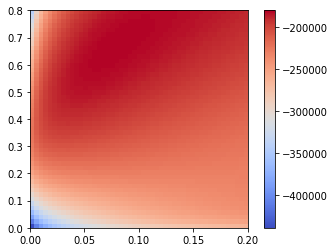

In [30]:
plotLikelihood(result[0])

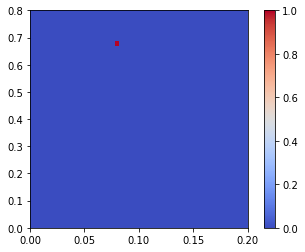

In [31]:
scaledR = result[0]-max(max(i) for i in result[0])
expR = 10**(scaledR)
plotLikelihood(expR)

In [22]:
# pickle_out = open("pickled_grid_px50","wb")
# pickle.dump(expR, pickle_out)
# pickle_out.close()

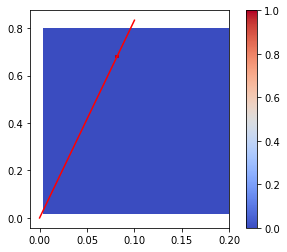

In [32]:
def plotLikelihood(result):
    #Does some transformations to ensure that the graph is square, 
    # with r on x axis and rho on y, both increasing from bottom left
    plt.imshow((np.flip(result,axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0.004,0.2,0.016,0.8],aspect=0.2/0.8)
#     plt.imshow((np.flip(np.transpose(result),axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0.1,1,0.02,0.2],aspect=5)
    x = np.linspace(0,0.1,50)
    y = x/0.12
    plt.plot(x, y, '-r', label='y=2x+1')
    plt.colorbar()
    plt.show()

plotLikelihood(expR)

In [33]:
allSum = sum([sum(r) for r in expR])
rhoNormalised = [sum(rho) for rho in expR]/allSum
rNormalised = [sum(rho) for rho in np.transpose(expR)]/allSum
rDistribution = np.cumsum(rNormalised)
print(np.where(rDistribution>0.025))
print(np.where(rDistribution<0.975))

(array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18]),)


In [34]:
rRange[19]

0.08

In [35]:
rhoDistribution = np.cumsum(rhoNormalised)
print(np.where(rhoDistribution>0.025))
print(np.where(rhoDistribution<0.975))

(array([41, 42, 43, 44, 45, 46, 47, 48]),)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40]),)


In [36]:
rhoRange[41]

0.672

In [37]:
rRange[19]/rhoRange[41]

0.11904761904761904

In [38]:
0.2/15

0.013333333333333334